In [1]:
pkg image load

In [2]:
function padded = padding(matrix, type_of, mask_size)

    % Como usar esta funcion
    % matrix es el valor de la imagen (si es a color, debera ser convertida a escala de grises o binarizarse)
    % type_of es el tipo de padding, 1 es el padding con reflejo, 2 es el padding con zeros (recomendado
    % para morfologia)
    % mask_size  es el TAMANO de la mascara, no la mascara, por que si se desea pasar la mascara, se debe usar
    % size(<mascara>) , nunca pasar la mascara.
    
    [x,y] = size(matrix);
    m_x = mask_size(1);
    m_y = mask_size(2);
    
    if m_x == m_y
        n_ref = (m_x - 1) / 2;
        
        % Mirrored
        if type_of == 1
            temp = matrix;
            
            % left - right
            temp = [fliplr(matrix(:,1:n_ref)) , matrix, fliplr(matrix)(:,1:n_ref)];
            temp = [fliplr(rot90(temp(1:n_ref,:),2)) ; temp ; fliplr(rot90(temp,2)(1:n_ref,:))];
            padded = temp;
        % Zero-ed
        elseif type_of == 2
            temp = zeros(x + 2 * n_ref, y + 2 * n_ref);
            temp(1 + n_ref:end - n_ref,1 + n_ref:end - n_ref) = matrix;
            padded = temp;
        else
            padded = zeros(x,y);
        end
    else
        padded = zeros(x,y);
    end
end

In [3]:
function output = aMax(matrix_D)
    output = max(max(matrix_D));
end

function output = aSum(matrix_D)
    output = sum(sum(matrix_D));
end

function output = aMin(matrix_D)
    output = min(min(matrix_D));
end

function output = L2(glob_max)
    L = ceil(log2(glob_max + 1));
    output = pow2(L);
end

In [4]:
function [output, spc_out] = histograma(imgData, ref_max)
    
    output = zeros(1,ref_max+1);
    spc_out = zeros(1,ref_max+1);
    
    prev = 1;
    prev_tmp = 0;
    for ii  = double(unique(imgData)')
        temp = aSum(imgData == ii);
        prev_tmp = prev_tmp + temp;
        
        output(ii+1) = temp;
        spc_out(prev:ii+1) = prev_tmp;
        
        prev = ii + 2;
        if prev > ref_max + 1
            prev = ref_max + 1;
        end
    end
    
    spc_out = cumsum(output);
end

In [5]:
function equalized = histEqualizer(imgData)
    imgData = double(imgData);
    
    [M, N] = size(imgData);
    equalized = zeros(M, N);
    
    glob_max = aMax(imgData);
    L_1 = L2(glob_max) - 1;
    
    [reg_hist, cum_hist] = histograma(imgData, L_1);
    p_i = double(cum_hist) / (M * N); 
    
    for ii = unique(imgData)'
        new_val = L_1 * p_i(ii + 1);
        
        equalized(find(imgData == ii)) = new_val;
    end
    
    equalized = uint8(round(equalized));
end

In [6]:
function equalized = contrastStretching(imgData, lazzo, verbose)
    imgData = double(imgData);
    ref_min = aMin(imgData);
    ref_max = aMax(imgData);
    
    new_ref_min = floor((1 - lazzo) * ref_min);
    new_ref_max = floor((1 + lazzo) * ref_max);
    
    if new_ref_min < 0
        new_ref_min = 0;
    elseif new_ref_min > 255
        new_ref_min = 255;
    end
    
    if new_ref_max < 0
        new_ref_max = 0;
    elseif new_ref_max > 255
        new_ref_max = 255;
    end
    
    if verbose
        disp('OLD RANGE')
        disp(ref_min)
        disp(ref_max)
        disp('NEW RANGE')
        disp(new_ref_min)
        disp(new_ref_max)
    end
    
    if (ref_max - ref_min) < 1e-16
        equalized = ones(size(imgData)) * ref_min;
    else
        equalized = (imgData - ref_min) / (ref_max - ref_min);
        equalized = equalized * (new_ref_max - new_ref_min);
        equalized = equalized + new_ref_min;
        equalized = uint8(floor(equalized));
    end
end

In [7]:
function new_base = zerobase(dataMatrix)
    new_base = ((dataMatrix - aMin(dataMatrix)) / (aMax(dataMatrix) - aMin(dataMatrix)));
end

In [8]:
function output = Binarization(imD,threshold);

    [fBin,cBin]=size(imD);

    for i=1:fBin
        for j=1:cBin
            if imD(i,j)<=threshold
                imageBin(i,j) = 0;
            else
                imageBin(i,j) = 255;
            end
        end
    end

    output = imageBin;
end

In [9]:
function umbral=otsu(matrix)
    [f,c] = size(matrix);
    [aa, hN] = histograma(uint8(matrix), 255);

    mayor = -1;
    umbral = -1;

    for t=1:256
        w1 = 1e-16;
        u1 = 1e-16; u2 = 1e-16;
        for i=1:t
            w1 = w1 + double(hN(i));
        end
        w2 = 1 - w1;
        
        if w2 == 0
            w2 = 1e-16;
        end

        for i=1:t
            c1 = (hN(i)/w1);
            u1 = u1 + c1*i;
        end
        for i=t+1:256
            c2 = (hN(i)/w2);
            u2 = u2 + c2*i;
        end
        ut = w1*u1 + w2*u2;

        B = w1*(u1 - ut)^2 + w2*(u2 - ut)^2;
        if(B > mayor)
            mayor = B;
            umbral = t;
        end
    end
end

In [10]:
function morph_matrix = morphologic_converter(image, operation, structural_element, gray)

    % como usar esta funcion
    % image es la imagen CON PADDING, no usar esta funcion sin aplicar el padding primero
    % operation es la operacion fundamental a aplicar : 1 es Dilatacion , 2 es Erosion
    % structural_element es , como su nombre dice, el elemento estructural, NO USAR TAMANOS PARES (3, 5, 7)
    % gray es un valor binario (true / false) , seleccionar true ejectua la funcion en modo escala de grises
    % ejecutarla usando el valor false, trabaja de forma binaria.
    
    gen_img= image;
    
    [x,y]=size(gen_img);
    morph_matrix=zeros(x,y);
    
    n_ref = (size(structural_element)(1) - 1) / 2;
    struct_indx = find(structural_element);
    struct_sum = sum(sum(structural_element));
    
    if gray
        if operation == 1
            %dilatacion

            for s=1+n_ref:x-n_ref
                for t=1+n_ref:y-n_ref
                    temp = gen_img(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                    morph_matrix(s,t) =  max(temp(struct_indx));
                end
            end
        
        elseif operation == 2
            %erosion

            for s=1+n_ref:x-n_ref
                for t=1+n_ref:y-n_ref
                    temp = gen_img(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                    morph_matrix(s,t) = min(temp(struct_indx));
                end
            end
        end
    else
        if operation == 1
            %dilatacion
        
            for s=1+n_ref:x-n_ref
                for t=1+n_ref:y-n_ref
                    if gen_img(s,t) == 1
                        temp = gen_img(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                        temp(struct_indx) = 1;
                        current = morph_matrix(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                        current = current + temp;
                        current = current ~= 0;
                        morph_matrix(s-n_ref:s+n_ref, t-n_ref:t+n_ref) = current;
                    end
                end
            end
        
        elseif operation == 2
            %erosion

            for s=1+n_ref:x-n_ref
                for t=1+n_ref:y-n_ref
                    if gen_img(s,t) == 1
                        temp = gen_img(s-n_ref:s+n_ref, t-n_ref:t+n_ref);
                        if sum(sum(temp(struct_indx))) == struct_sum
                                morph_matrix(s,t) = 1;
                        end
                    end
                end
            end
        end
    end
    morph_matrix = morph_matrix(1+n_ref:end-n_ref, 1+n_ref:end-n_ref);
end

In [11]:
function morph_matrix = advance_morphologic_converter(image, operation, structural_element, gray)
    % image es la imagen CON PADDING, no usar esta funcion sin aplicar el padding primero
    % operation es la operacion fundamental a aplicar : 1 es Apertura , 2 es Clausura
    % structural_element es , como su nombre dice, el elemento estructural, NO USAR TAMANOS PARES (3, 5, 7)
    % gray es un valor binario (true / false) , seleccionar true ejectua la funcion en modo escala de grises
    % ejecutarla usando el valor false, trabaja de forma binaria.
    
    if operation == 1
        temp = morphologic_converter(image, 2, structural_element, gray);
        temp = padding(temp, 2, size(structural_element));
        morph_matrix = morphologic_converter(temp, 1, structural_element, gray);
        
    elseif operation == 2
        temp = morphologic_converter(image, 1, structural_element, gray);
        temp = padding(temp, 2, size(structural_element));
        morph_matrix = morphologic_converter(temp, 2, structural_element, gray);
        
    end
end

In [12]:
function structural_element = gen_struct(radio, pre_define)
    
    % como usar esta funcion
    % marcar un radio, SIEMPRE IMPAR
    % seleccionar un tipo de estructura: 
    % 1 Linea Vertical, 2 Linea horizonta, 3 Cuadrado, 4 Cruz, 5 Circulo, 6 Diamante
    
    structural_element = zeros(radio, radio);
    sub_rad = (radio - 1) / 2;
    switch pre_define
        case 1
            % linea vertical
            structural_element(:,1+sub_rad) = 1;
        case 2
            % linea horizontal
            structural_element(1+sub_rad, :) = 1;
        case 3
            % cuadrado
            structural_element = ones(radio,radio);
        case 4
            % cruz
            structural_element(:, 1+sub_rad) = 1;
            structural_element(1+sub_rad, :) = 1;
        case 5
            % circulo
            sub_rad_mid = sub_rad + 1;

            imageSizeX = radio;
            imageSizeY = radio;
            [columnsInImage rowsInImage] = meshgrid(1:imageSizeX, 1:imageSizeY);
            
            centerX = sub_rad_mid;
            centerY = sub_rad_mid;
            radius = sub_rad_mid;
            structural_element = (rowsInImage - centerY).^2 + (columnsInImage - centerX).^2 <= radius.^2;
        case 6
            % diamante
            structural_element(1:1+sub_rad,(end - sub_rad):end) = tril(ones(1+sub_rad));
            structural_element = structural_element + structural_element';
            structural_element = structural_element + rot90(structural_element);
            structural_element = structural_element ~= 0;
        otherwise
            structural_element = ones(radio, radio)
        end
end

In [13]:
!ls ./balanza/

IMG_20200928_173133859.jpg      IMG_20200928_173320270.jpg
IMG_20200928_173151548_HDR.jpg  IMG_20200928_173342205.jpg
IMG_20200928_173223443.jpg      IMG_20200928_173345264.jpg
IMG_20200928_173318305.jpg



In [14]:
% new_img = imread('./balanza/IMG_20200928_173133859.jpg');
new_img = imread('./balanza/IMG_20200928_173318305.jpg');
% new_img = imread('./balanza/IMG_20200928_173320270.jpg');

In [15]:
size(new_img)

ans =

   4160   3120      3



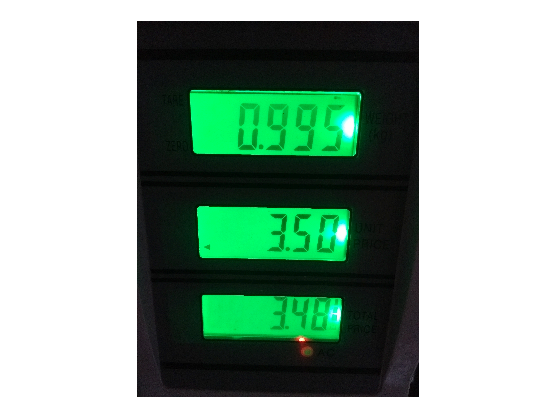

In [16]:
imshow(new_img)

In [17]:
n_g = new_img(:, : , 2);

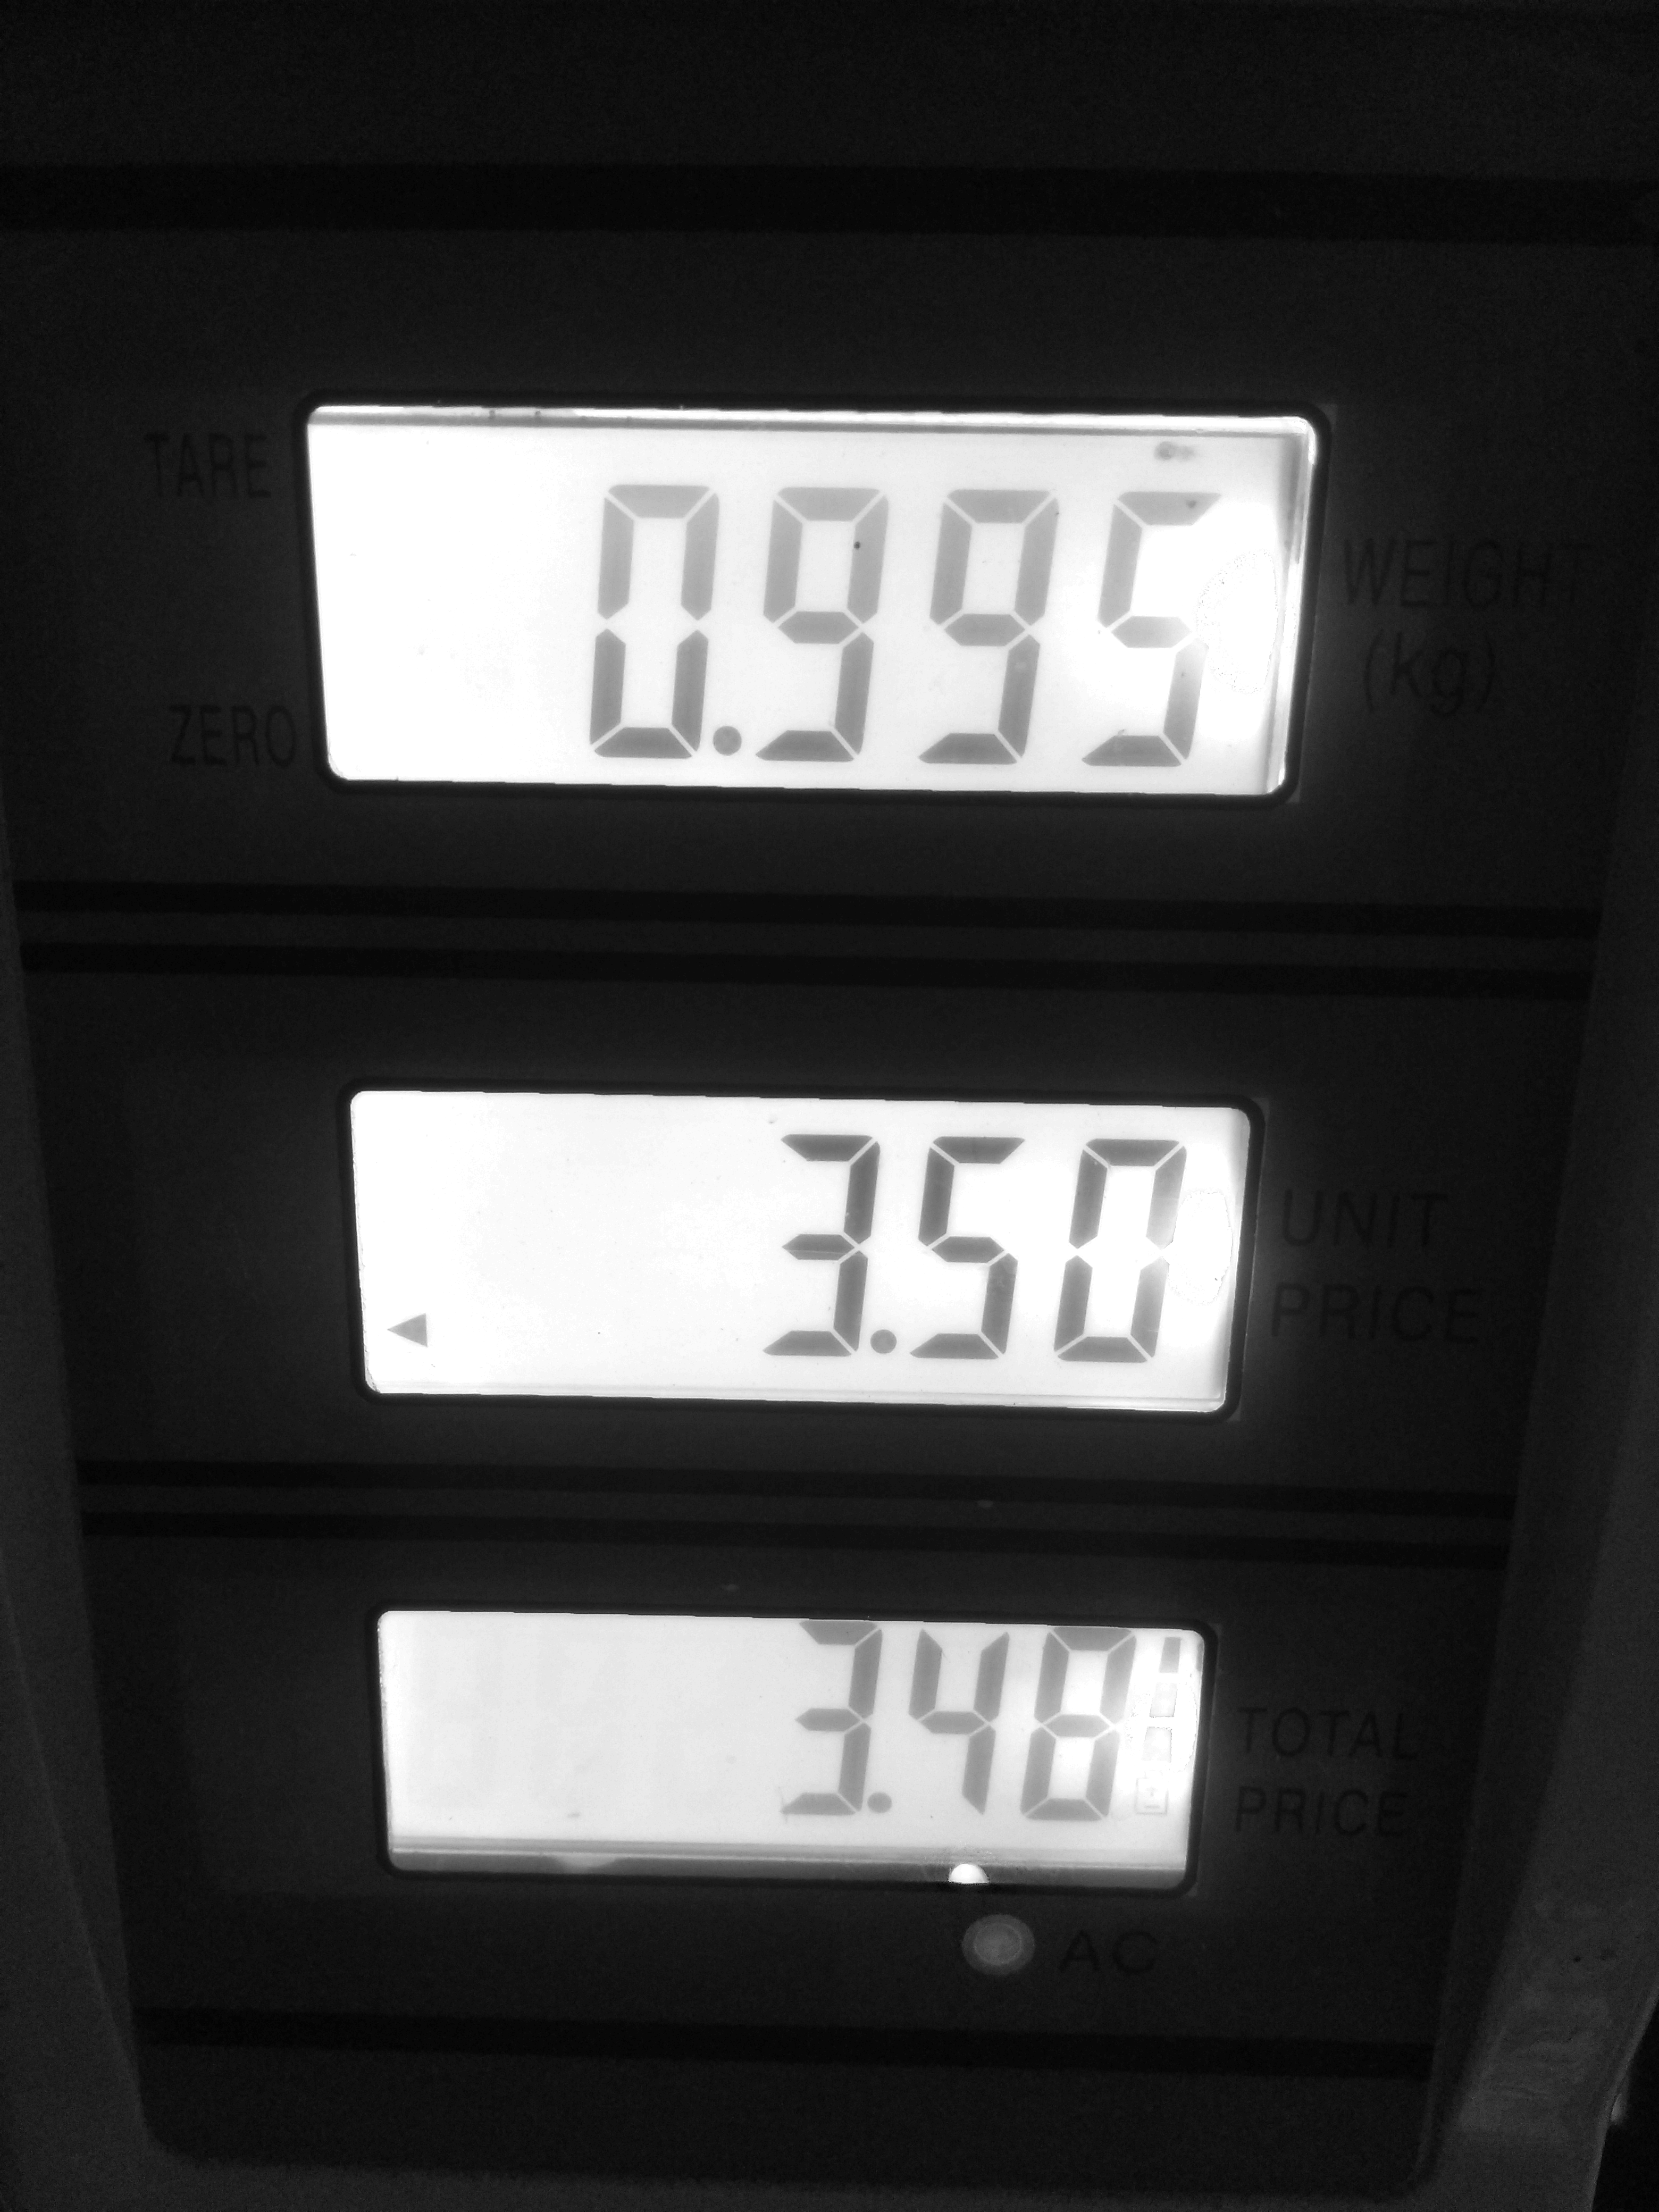

In [18]:
imshow(n_g)

In [19]:
thr = graythresh(n_g) * 255;

In [20]:
thr


thr =  124


In [21]:
n_g_b = (n_g < thr) .* 255;

In [22]:
current=n_g_b;

In [23]:
#PRECROP

perc = 0.1;
[x,y] = size(current);
x_pad = floor(x * perc);
y_pad = floor(y * perc);
current = current(+x_pad:end-x_pad, 1+y_pad:end-y_pad);
size(current)

ans =

   3329   2496



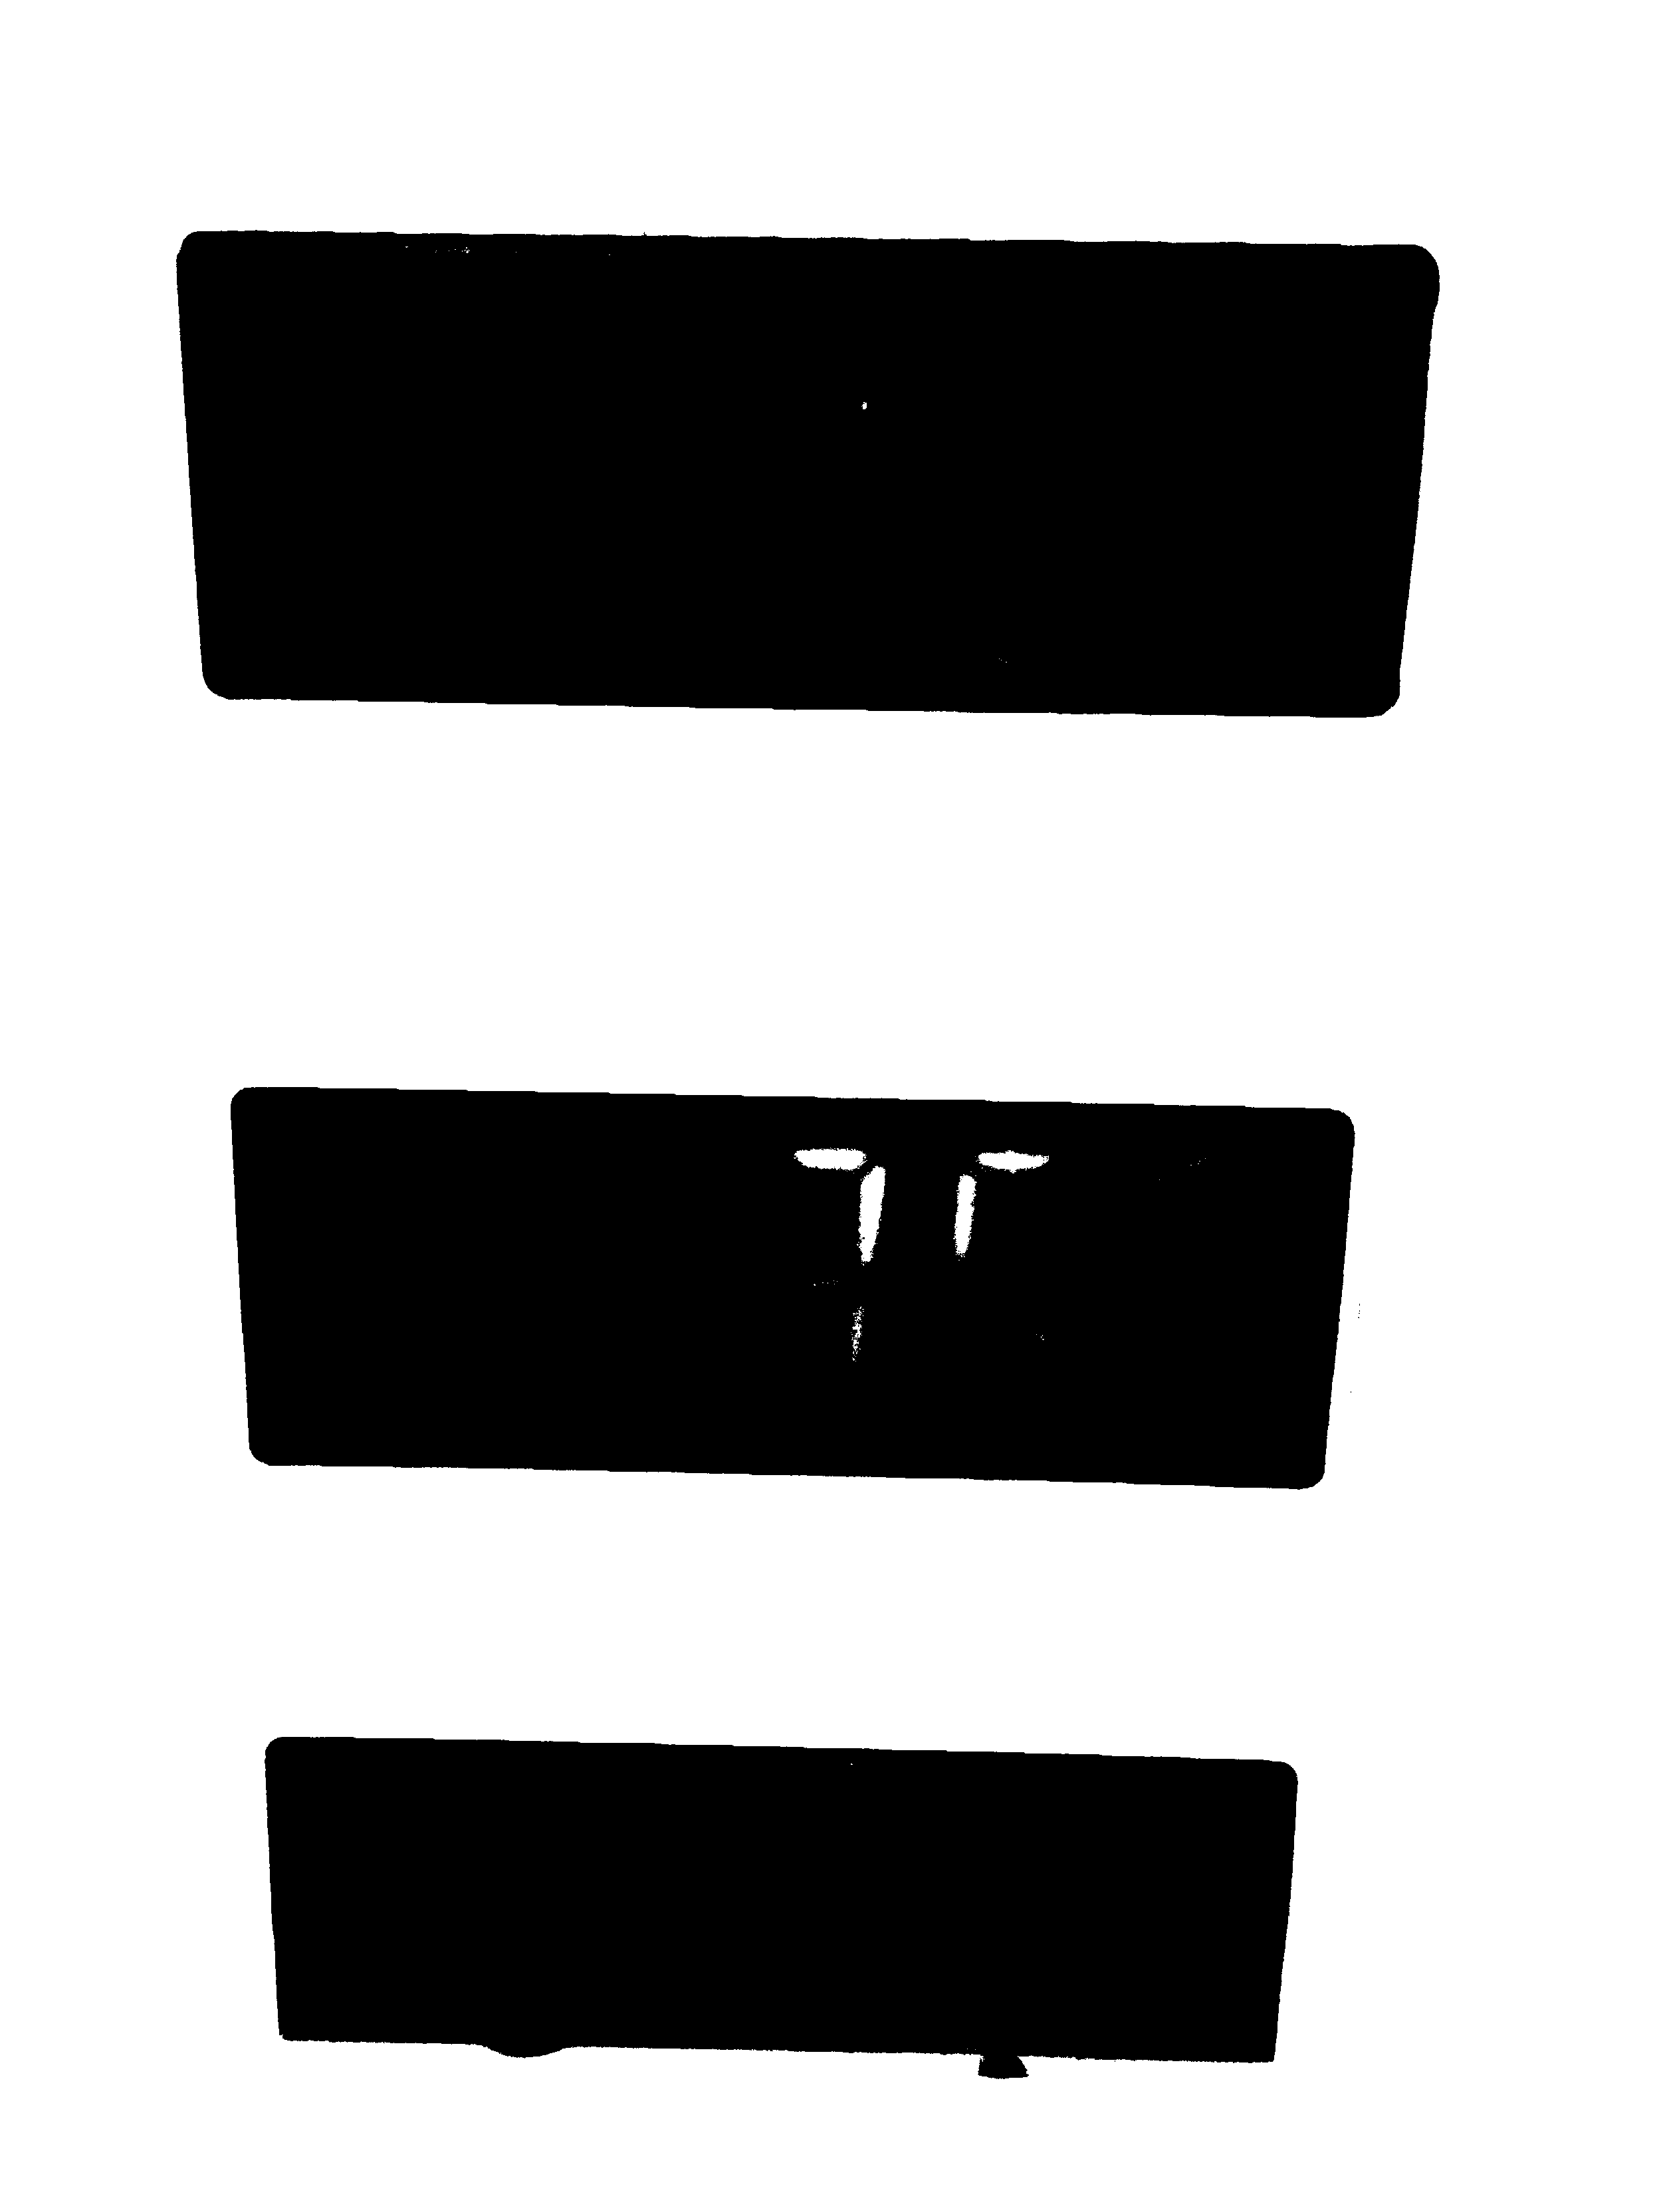

In [24]:
imshow(current * 255)

In [25]:
[x,y] = size(current)

x =  3329
y =  2496


In [26]:
unique(current)

ans =

     0
   255



In [27]:
nhood = 3;

empt_R = double(ones(x,y));
for ii=[1:1:x]
    test = sum(current(ii,:) ~= 255);
    if test == 0 
        empt_R(ii,:) = 0;
    end
end

empt_R_2 = double(zeros(x,y));
for ii=[1:1:x]
    if ii - nhood < 1
        ref_u = 1;
    else
        ref_u = ii - nhood;
    end
    
    if ii + nhood > x
        ref_l = x;
    else
        ref_l = ii + nhood;
    end
    
    test2_1 = aSum(empt_R(ref_u:ref_l,:) == 1);
    total = y * (1 + 2 * nhood);
    
    test = empt_R(ii,:);
    if test(1) == 1 
        if test2_1 / total  > 0.5
            empt_R_2(ii, :) = 1;
        end
    end
end

empt_C = double(ones(x,y));
for jj=[1:1:y]
    test = sum(current(:,jj) ~= 255);
    if test == 0
        empt_C(:, jj) = 0;
    end
end

empt_C_2 = double(zeros(x,y));
for jj=[1:1:y]
    if jj - nhood < 1
        ref_r = 1;
    else
        ref_r = jj - nhood;
    end
    
    if jj + nhood > y
        ref_l = y;
    else
        ref_l = jj + nhood;
    end
    
    test2_1 = aSum(empt_C(:,ref_r:ref_l) == 1);
    total = x * (1 + 2 * nhood);
    
    test = empt_C(:, jj);
    if test(1) == 1 
        if test2_1 / total  > 0.5
            empt_C_2(:, jj) = 1;
        end
    end
end

post_current = (empt_R_2 + empt_C_2) .* double(current);

In [28]:
unique(post_current-255)

ans =

  -255
     0
   255



In [29]:
post_current = uint8((post_current - 255 ~= 0) * 255);

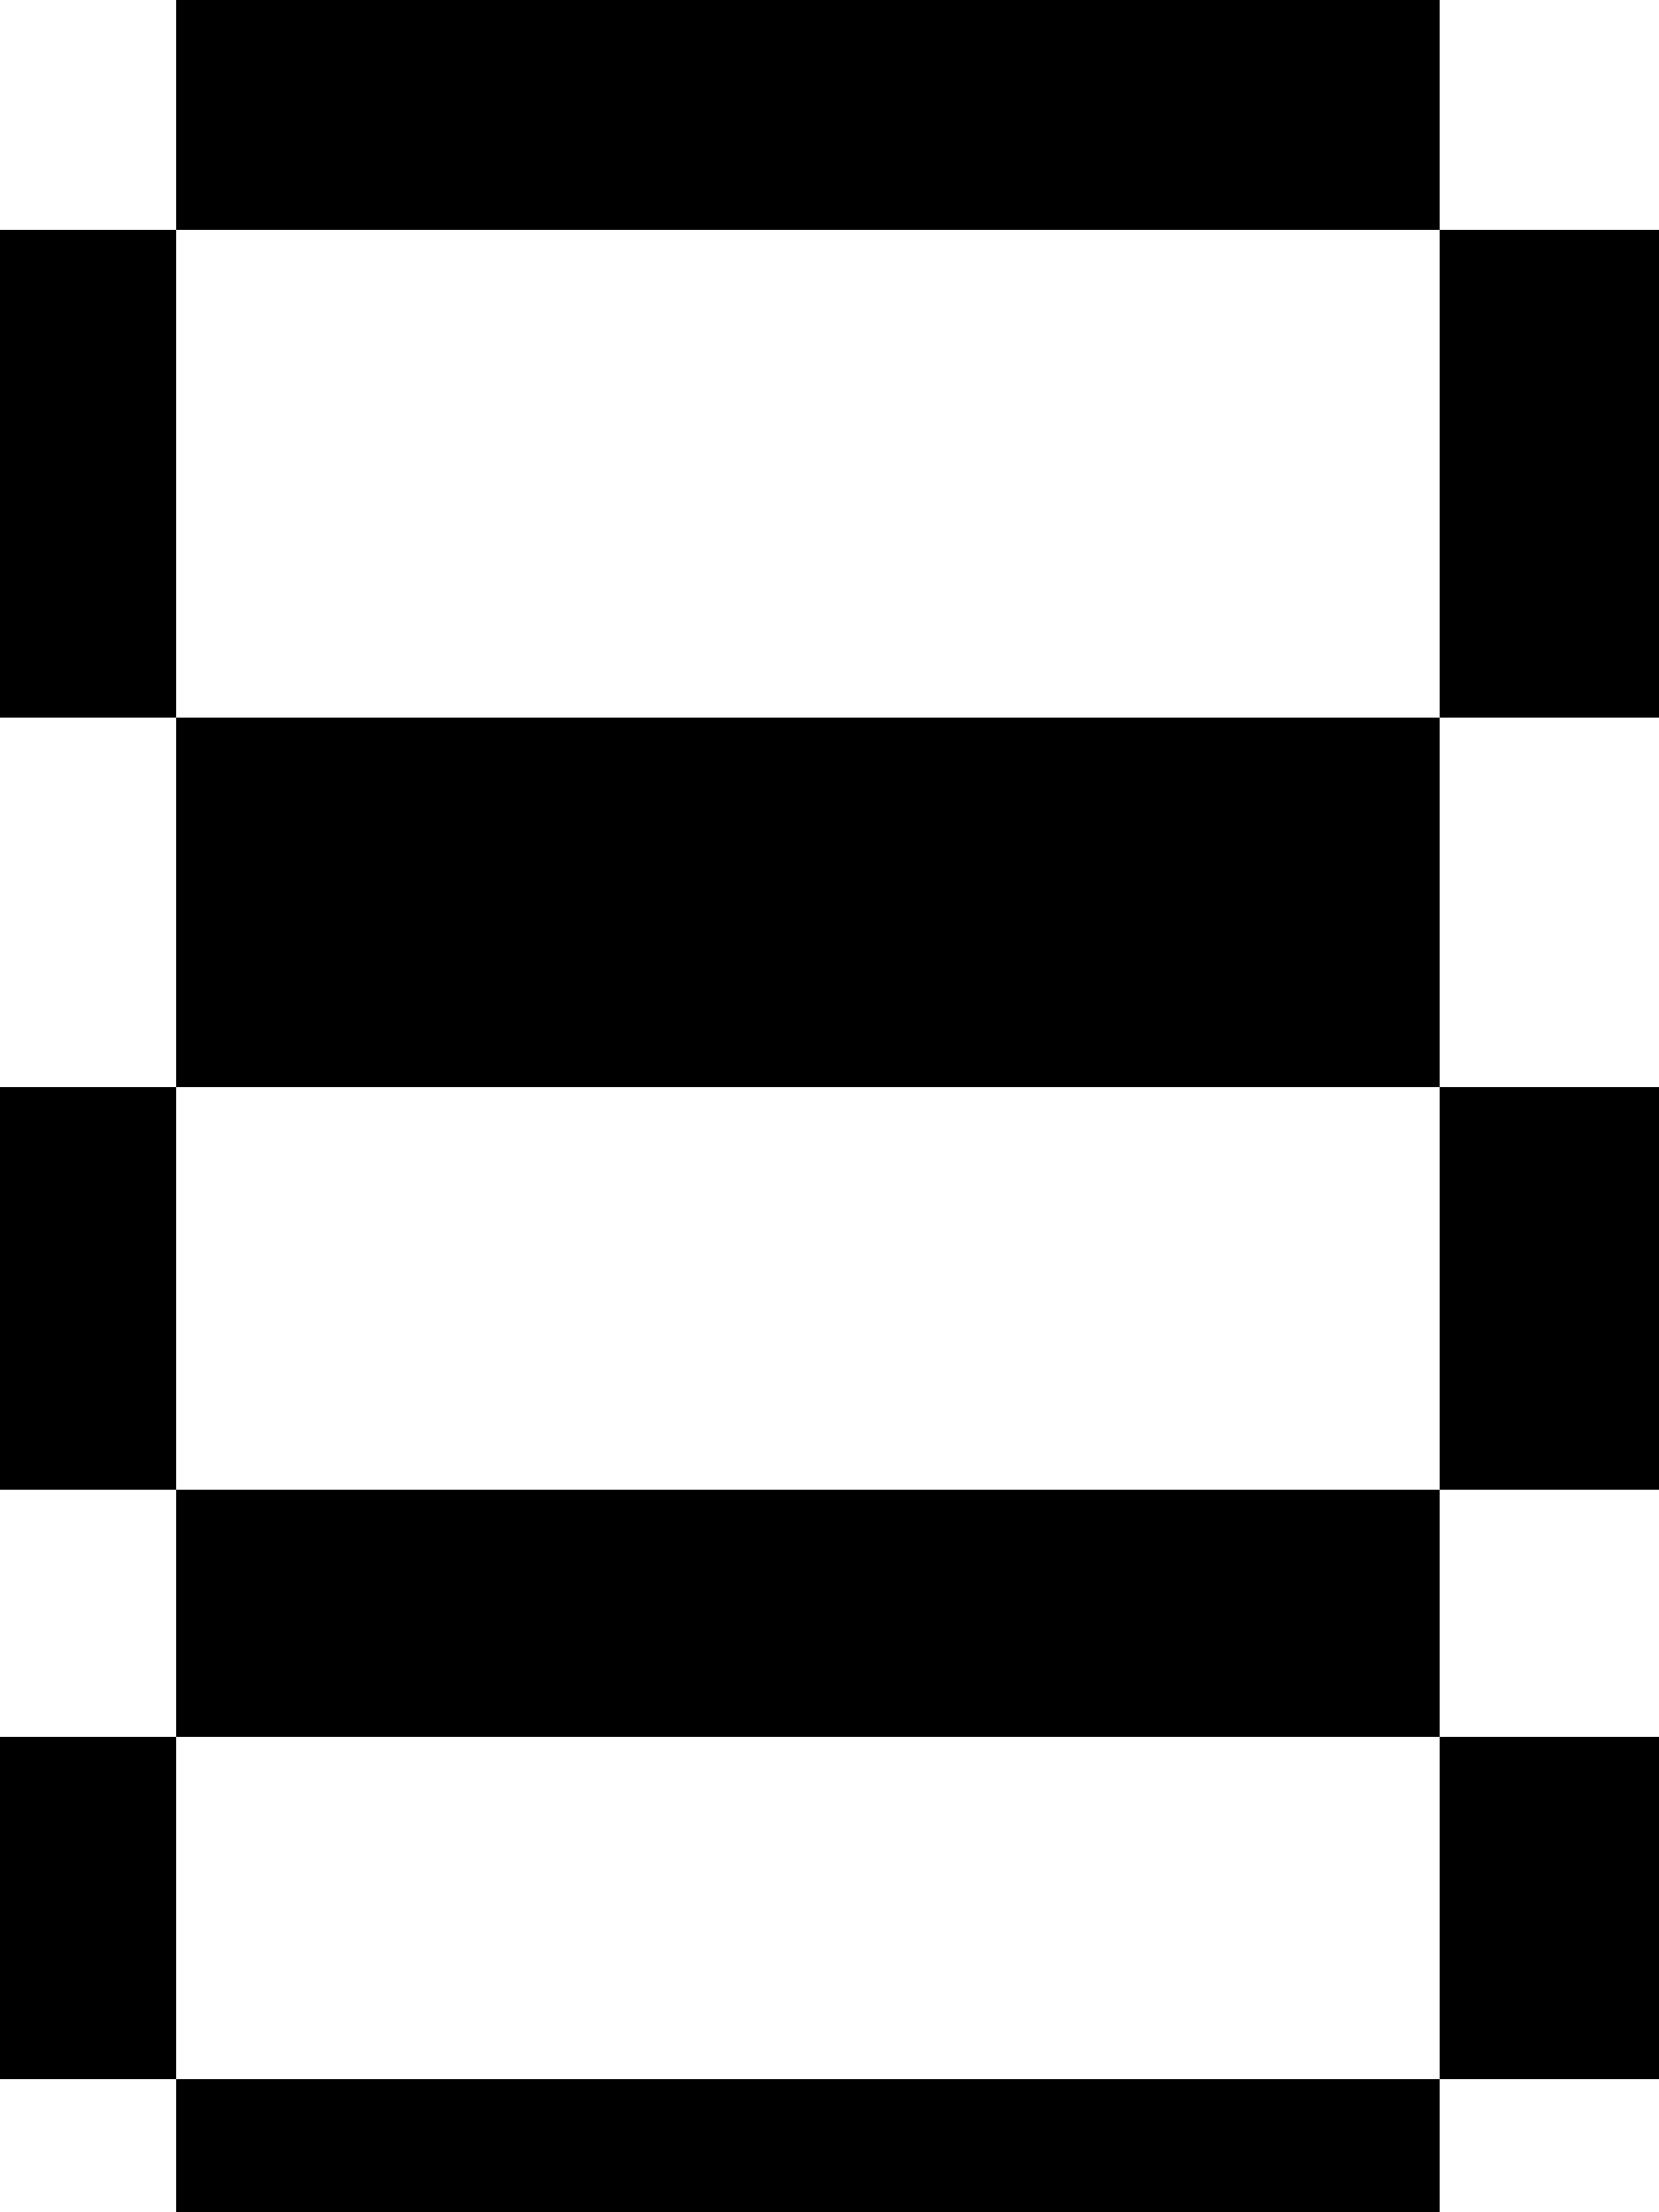

In [30]:
imshow(post_current)

In [31]:
ref_mask = post_current;

In [32]:
for ii=[1:1:x]
    test = ref_mask(ii,:);
    if test(1) == 255
        ref_mask(ii,:) = 0;
    end
end

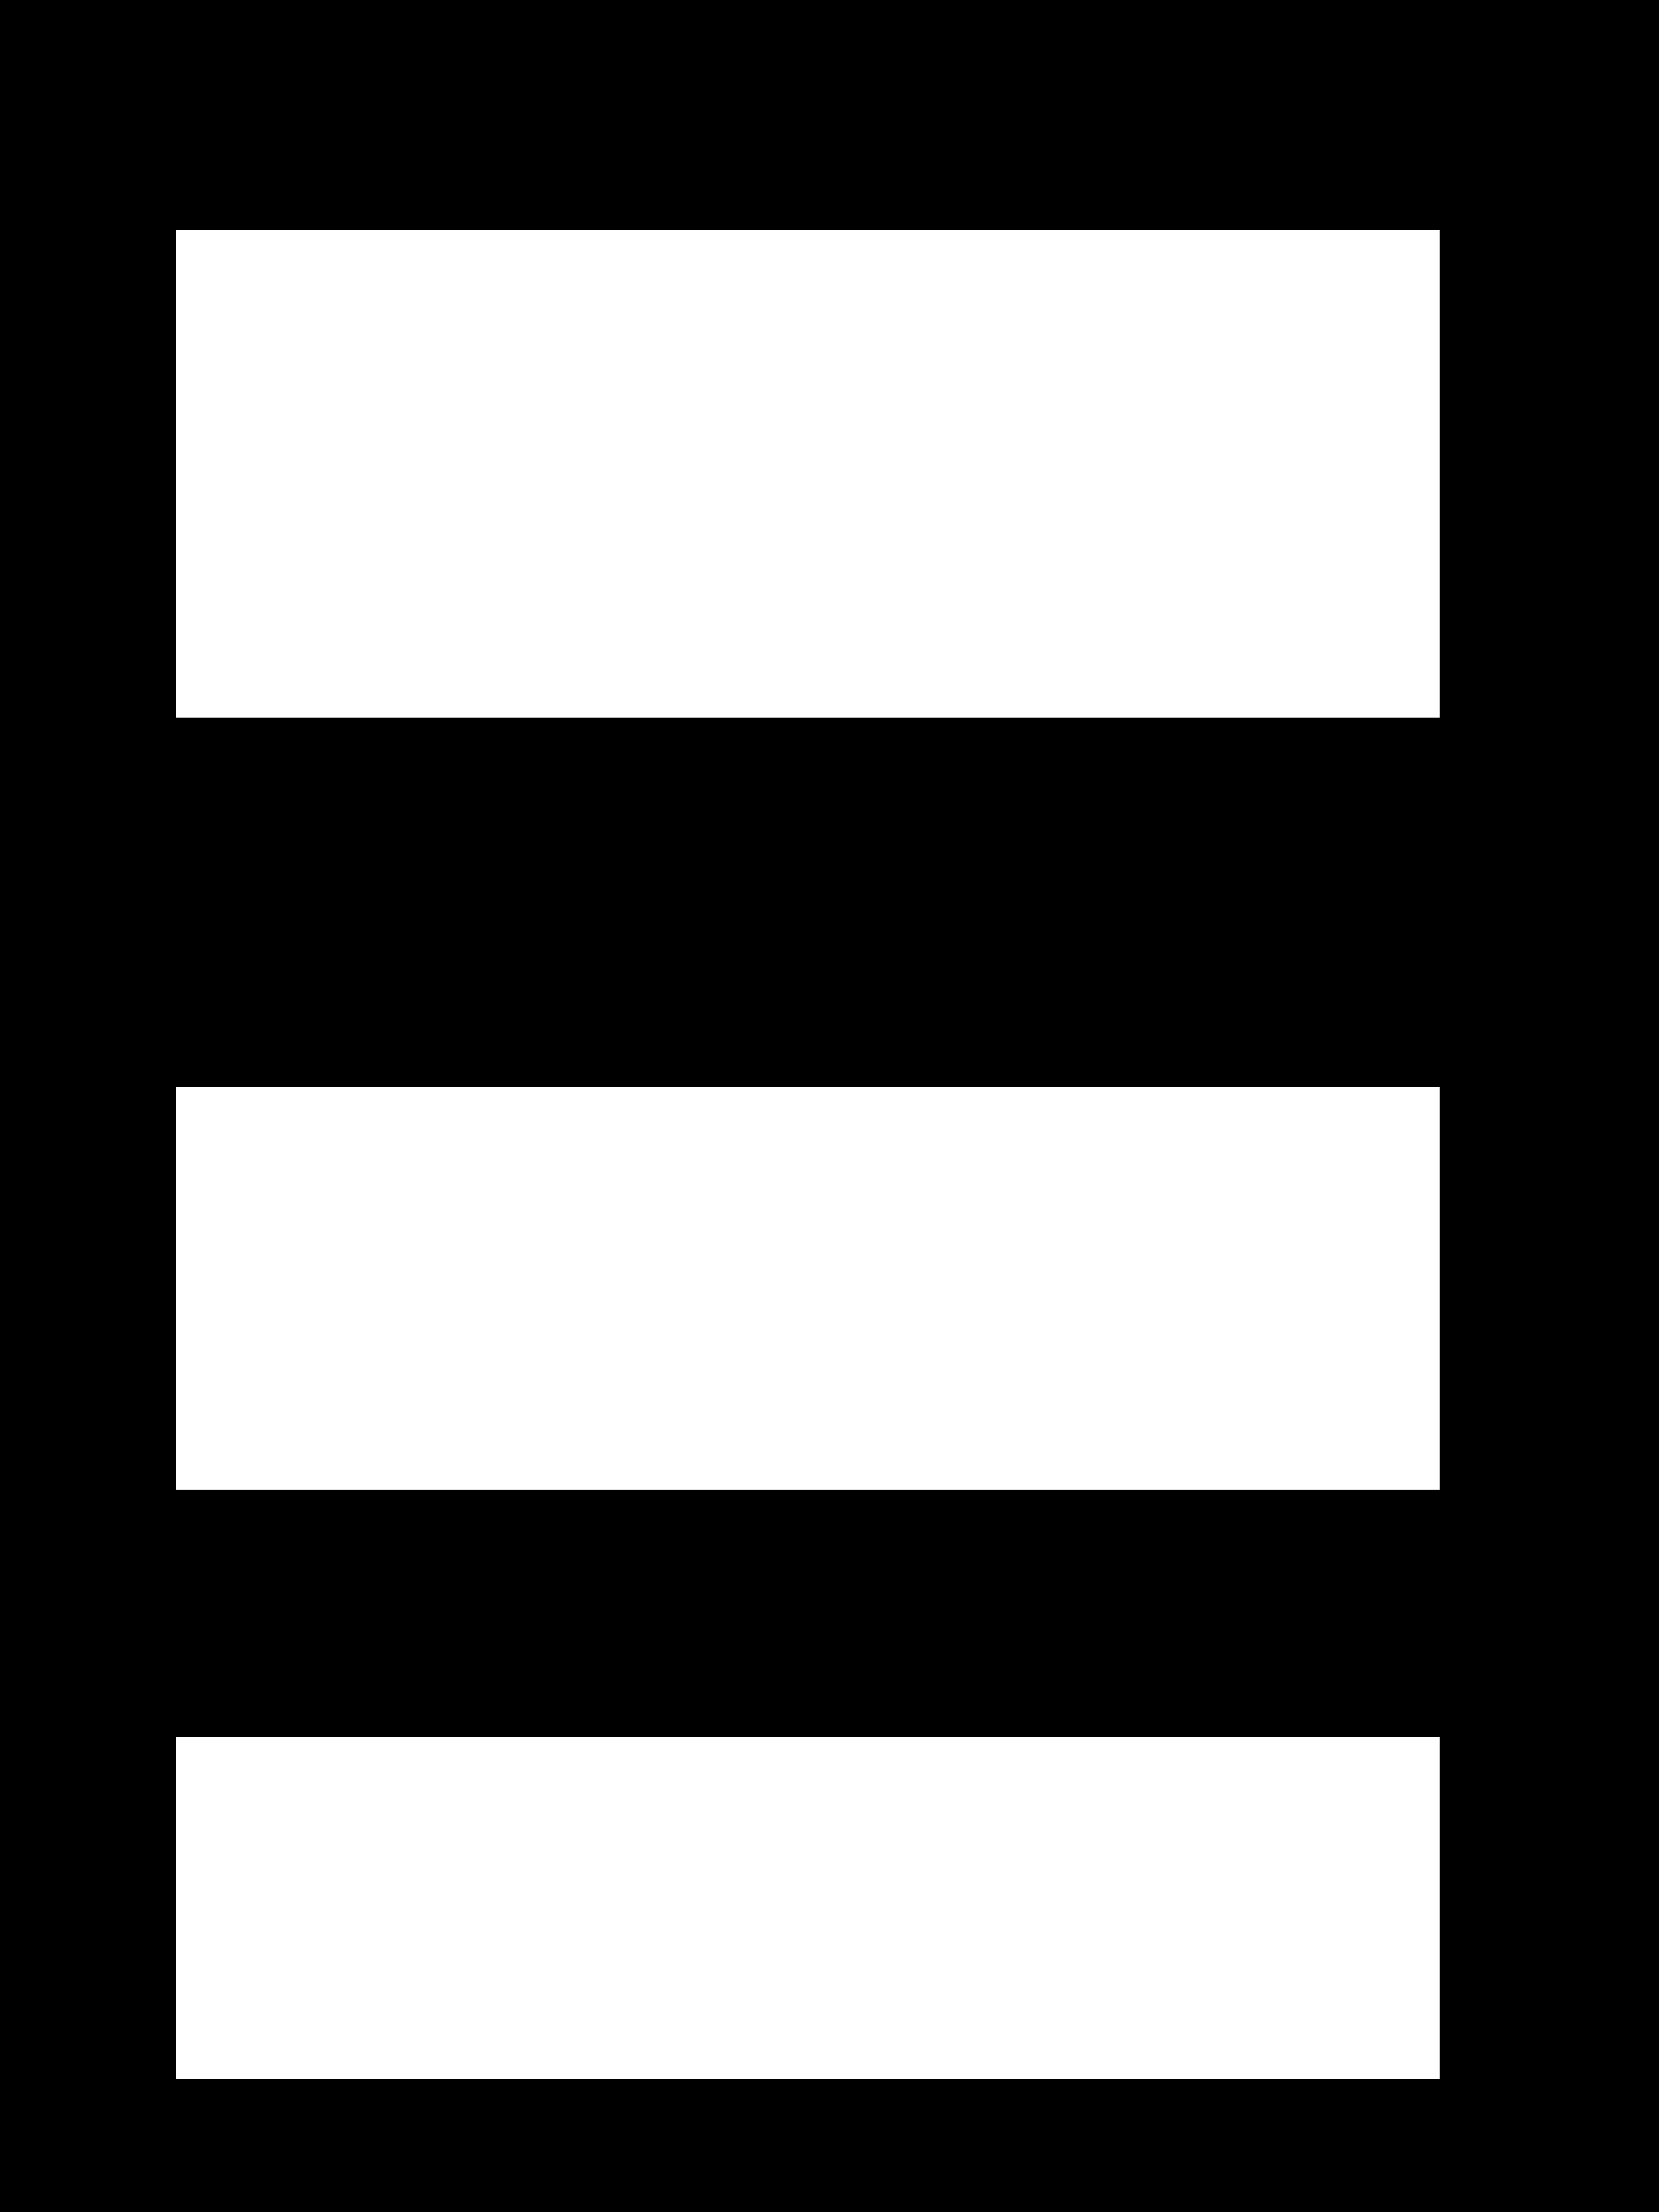

In [33]:
imshow(ref_mask)

In [34]:
first_match = false;
prev_flag = 0;
curr_flag = 0;
master_flag = true;
for ii=[1:1:x]
    test = ref_mask(ii,:);
    if master_flag
        control = sum(test == 255) ~= 0;
        if control
            first_match = true;
        else
            if first_match
                master_flag = false;
            end
        end
    else
        ref_mask(ii,:) = 0;
    end
end

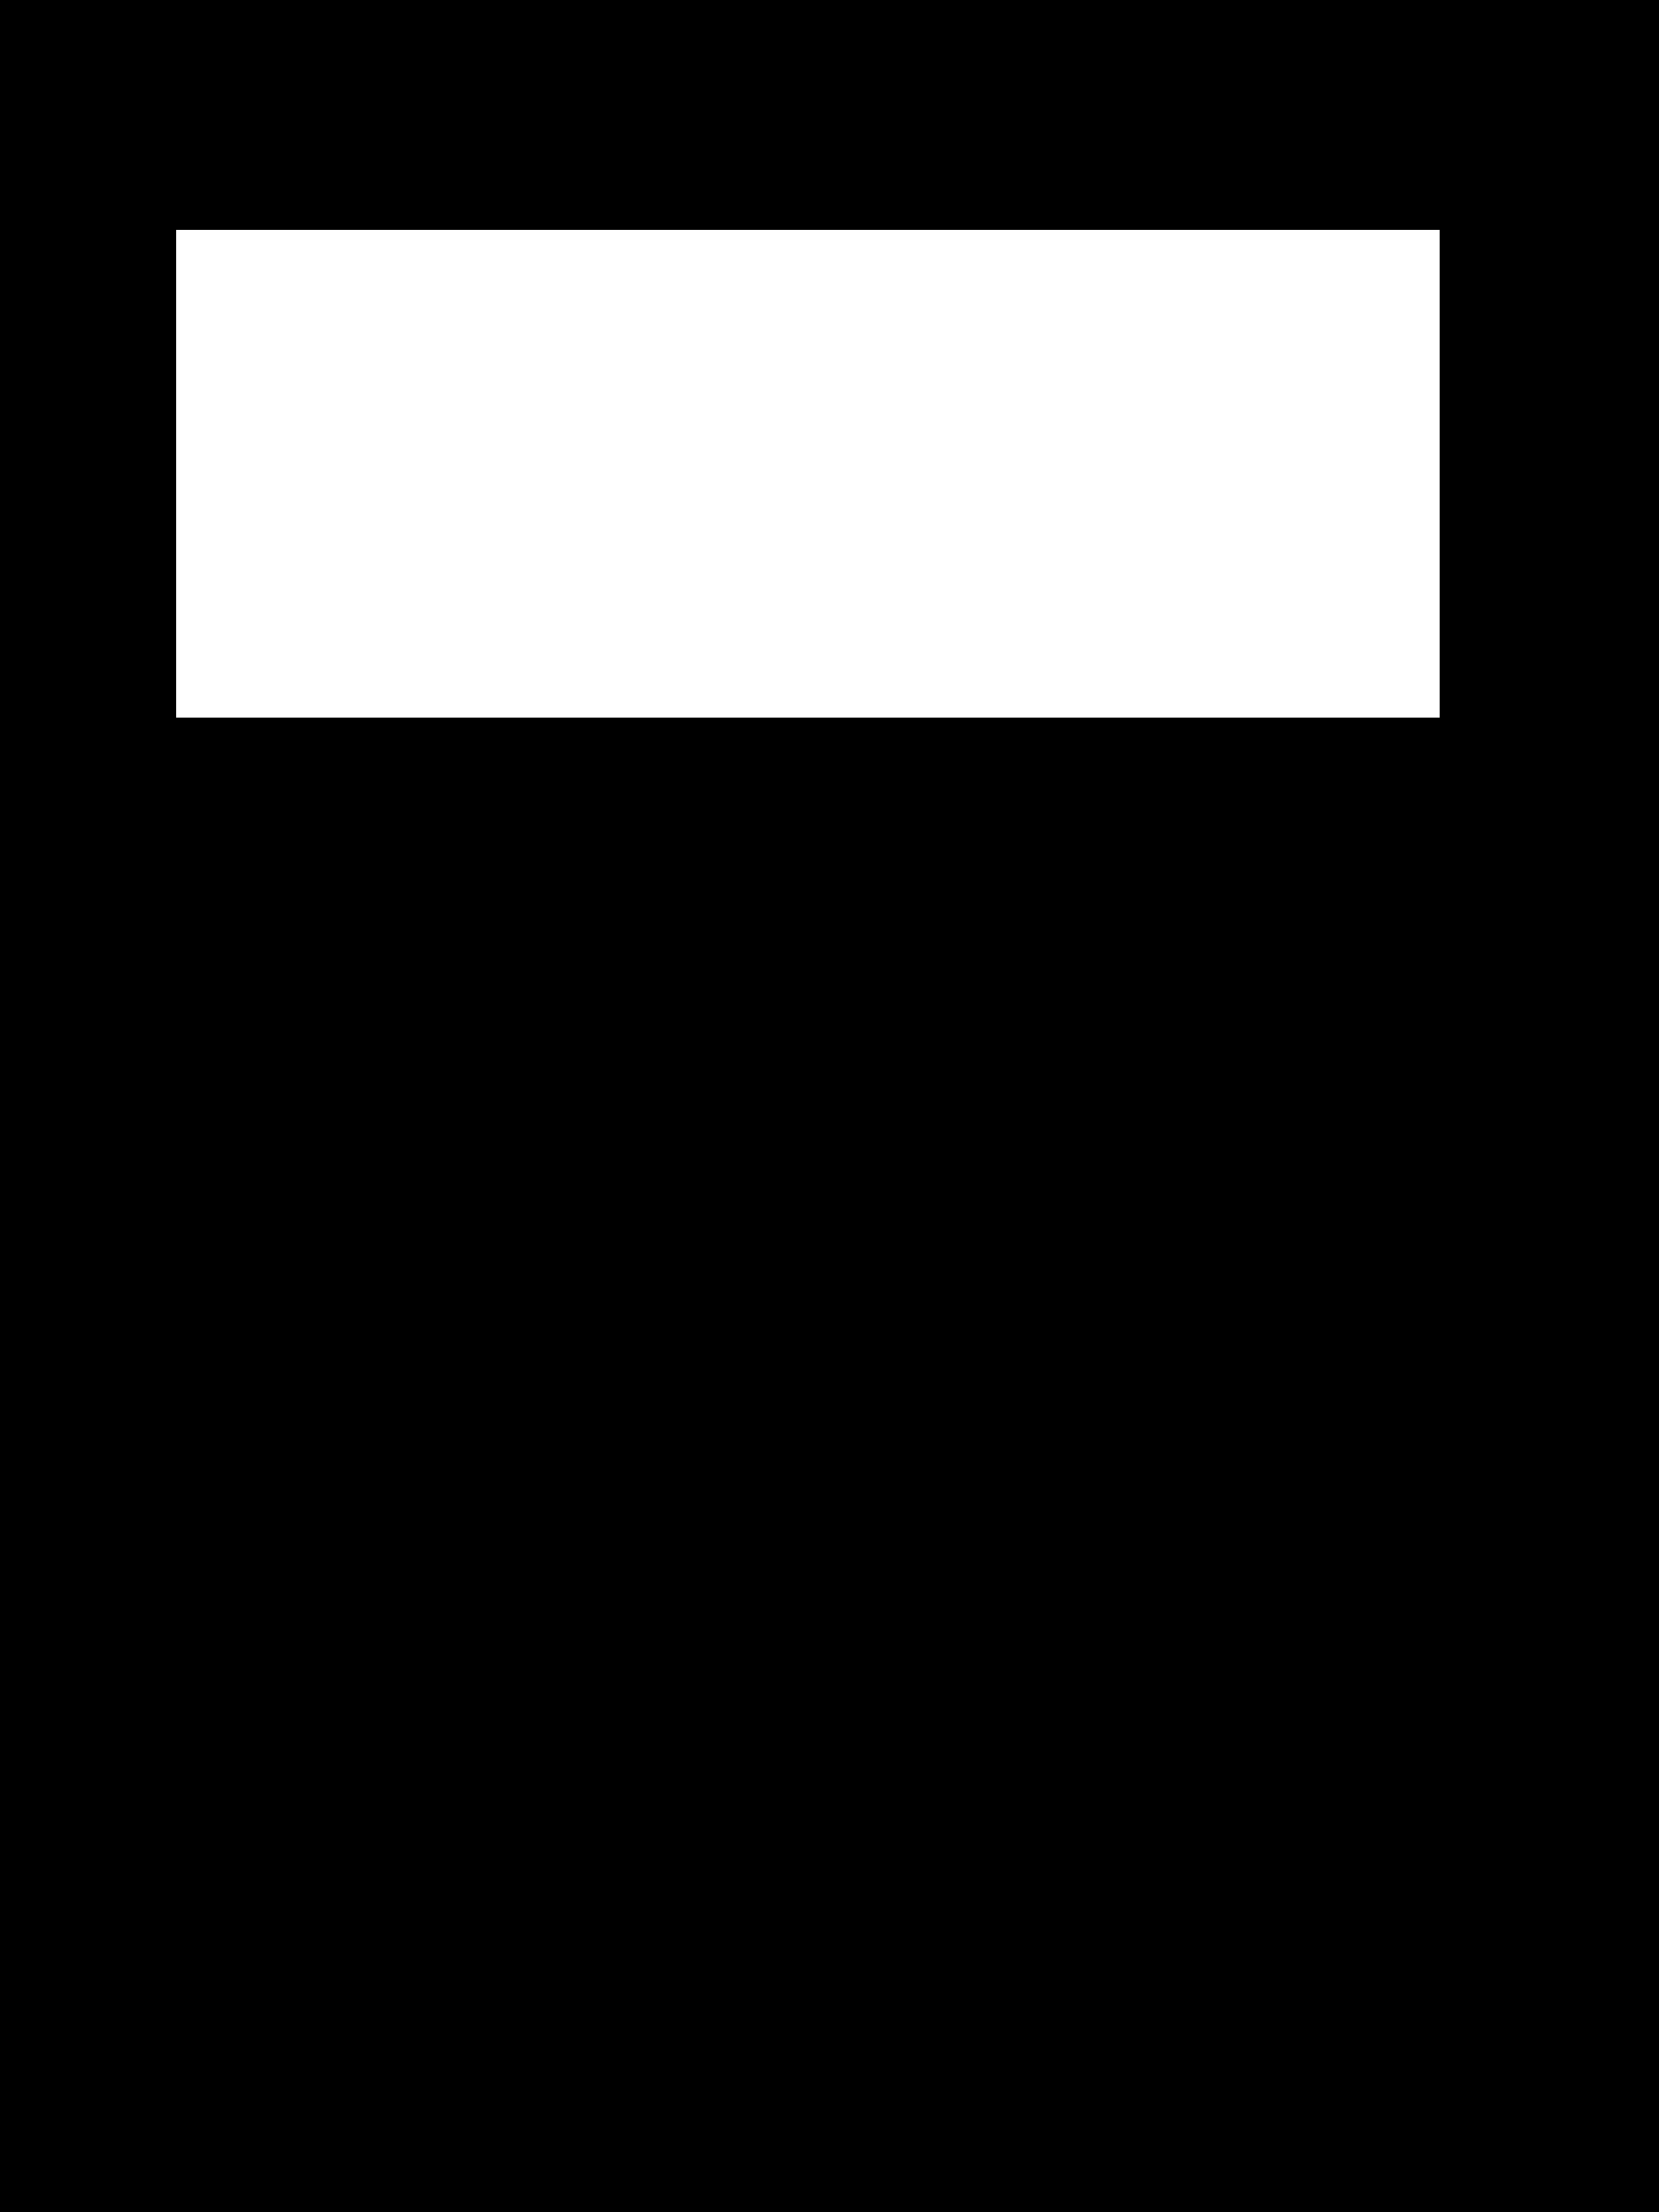

In [35]:
imshow(ref_mask)

In [36]:
size(ref_mask)
size(n_g_b)
x_pad
y_pad

ans =

   3329   2496

ans =

   4160   3120

x_pad =  416
y_pad =  312


In [37]:
rest_mask = zeros(size(n_g_b));

In [38]:
rest_mask(+x_pad:end-x_pad, 1+y_pad:end-y_pad) = ref_mask;

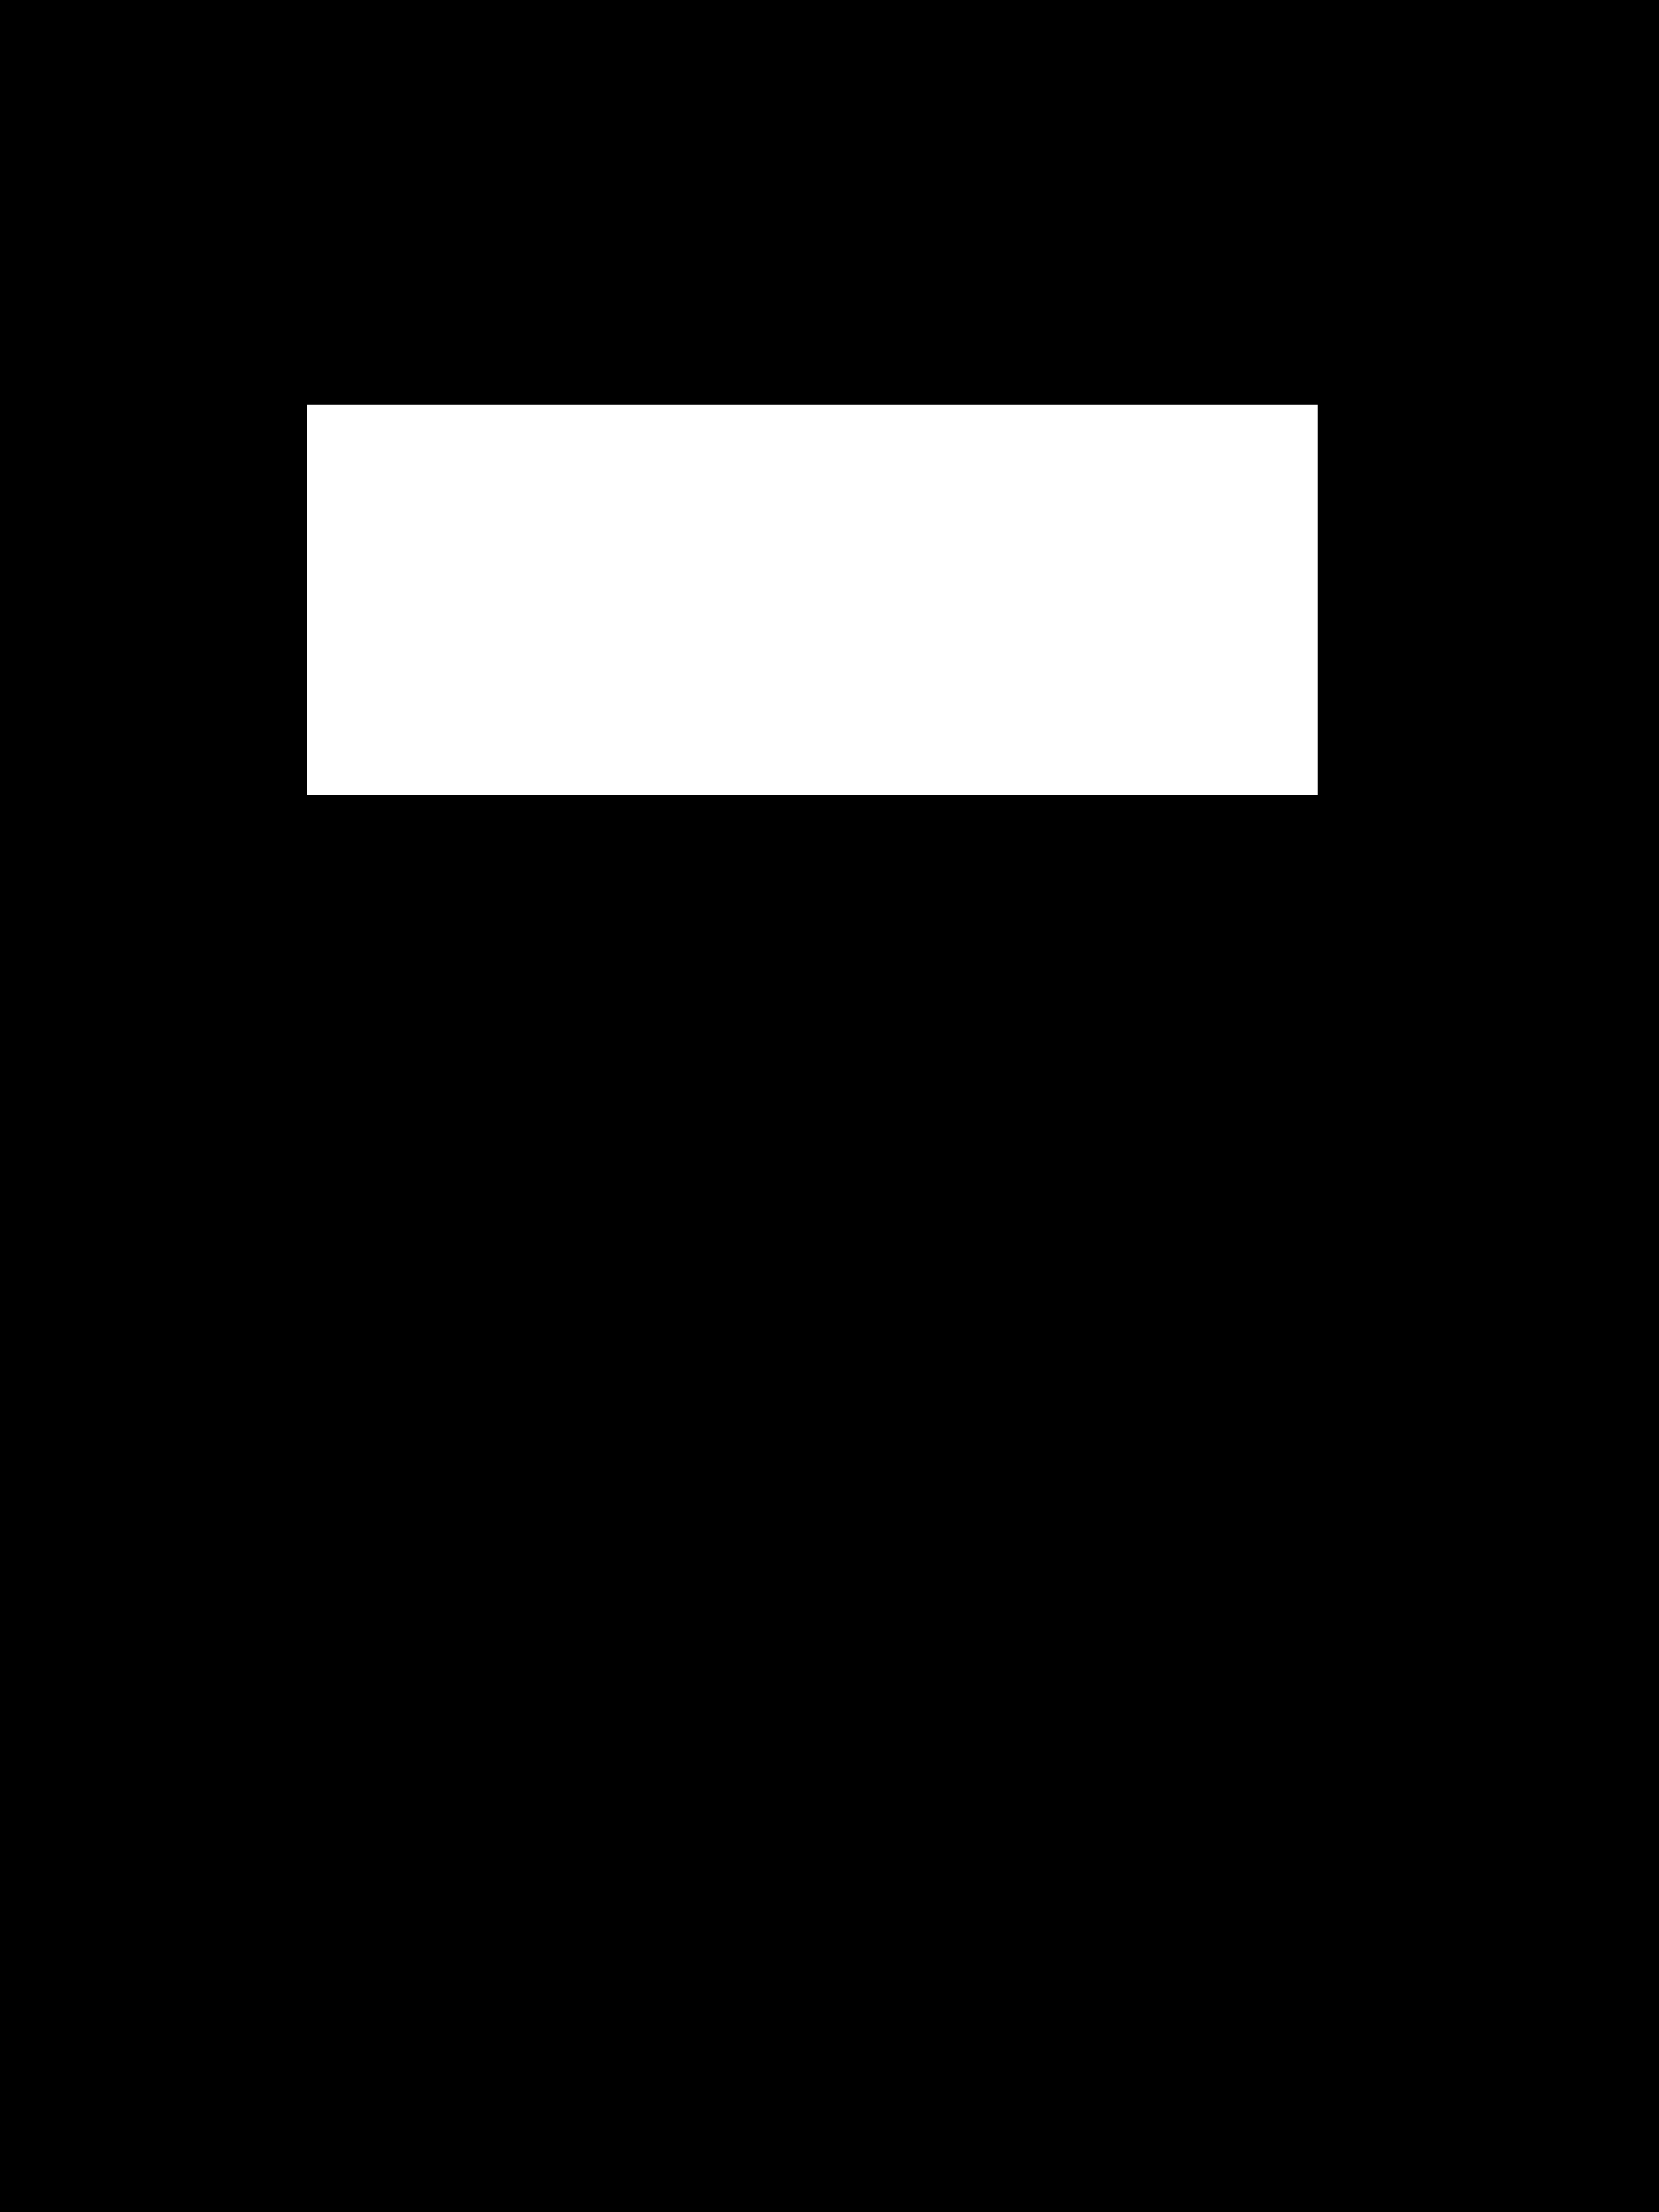

In [39]:
imshow(rest_mask)

In [40]:
min(find(rest_mask == 255))

ans =  2401082


In [41]:
max(find(rest_mask == 255))

ans =  10305815


In [42]:
[x_min,y_min] = ind2sub(size(rest_mask), min(find(rest_mask == 255)))

x_min =  762
y_min =  578


In [43]:
[x_max,y_max] = ind2sub(size(rest_mask), max(find(rest_mask == 255)))

x_max =  1495
y_max =  2478


In [44]:
current = new_img(x_min:x_max, y_min:y_max, :);

In [45]:
perc = 0.08;
[x,y,z] = size(current);
x_pad = floor(x * perc);
y_pad = floor(y * perc);
current = current(+x_pad:end-x_pad, 1+y_pad:end-y_pad, :);
size(current)

ans =

    619   1597      3



In [46]:
%fine crop

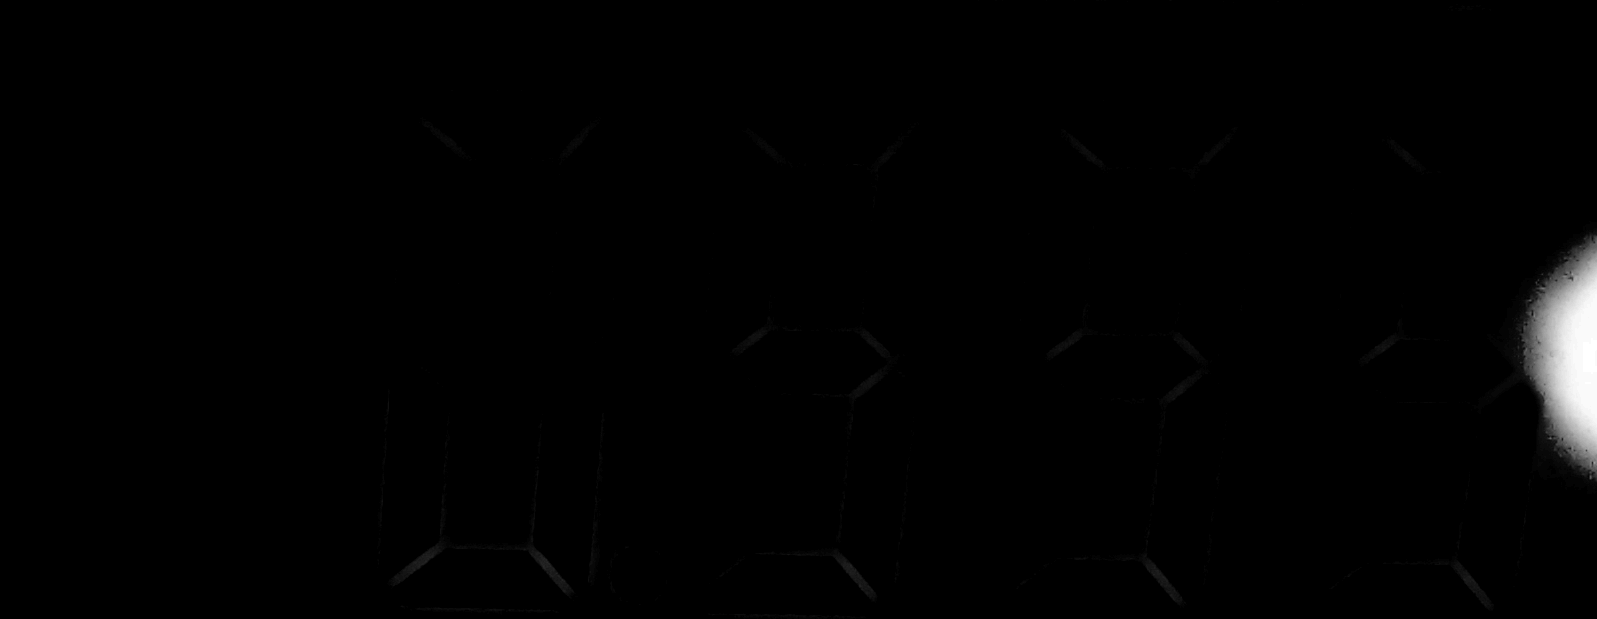

In [47]:
imshow(current(:, :, 1))

In [48]:
red = current(:,:,1);

thr_red =  99


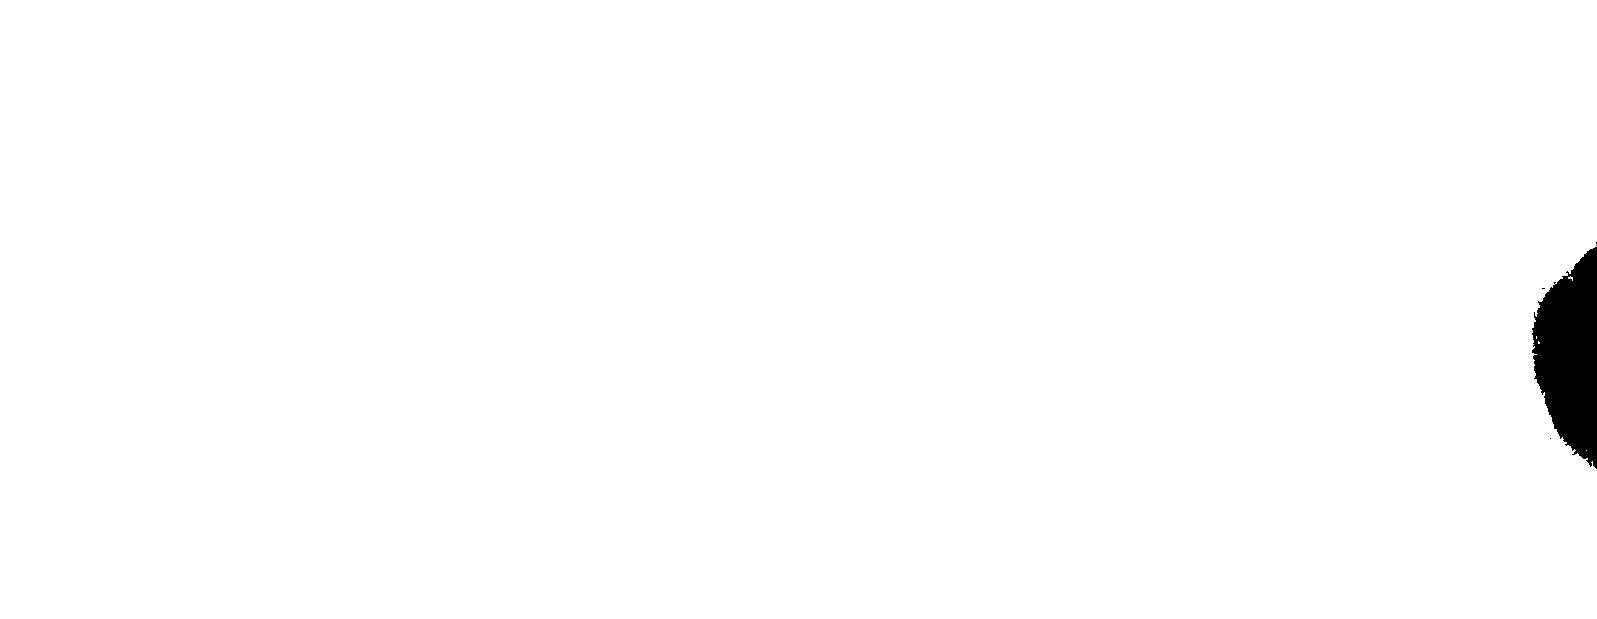

In [49]:
thr_red = graythresh(red) * 255;
thr_red
imshow((red < thr_red) .* 255)

In [50]:
green = current(:, :, 2);

thr =  209


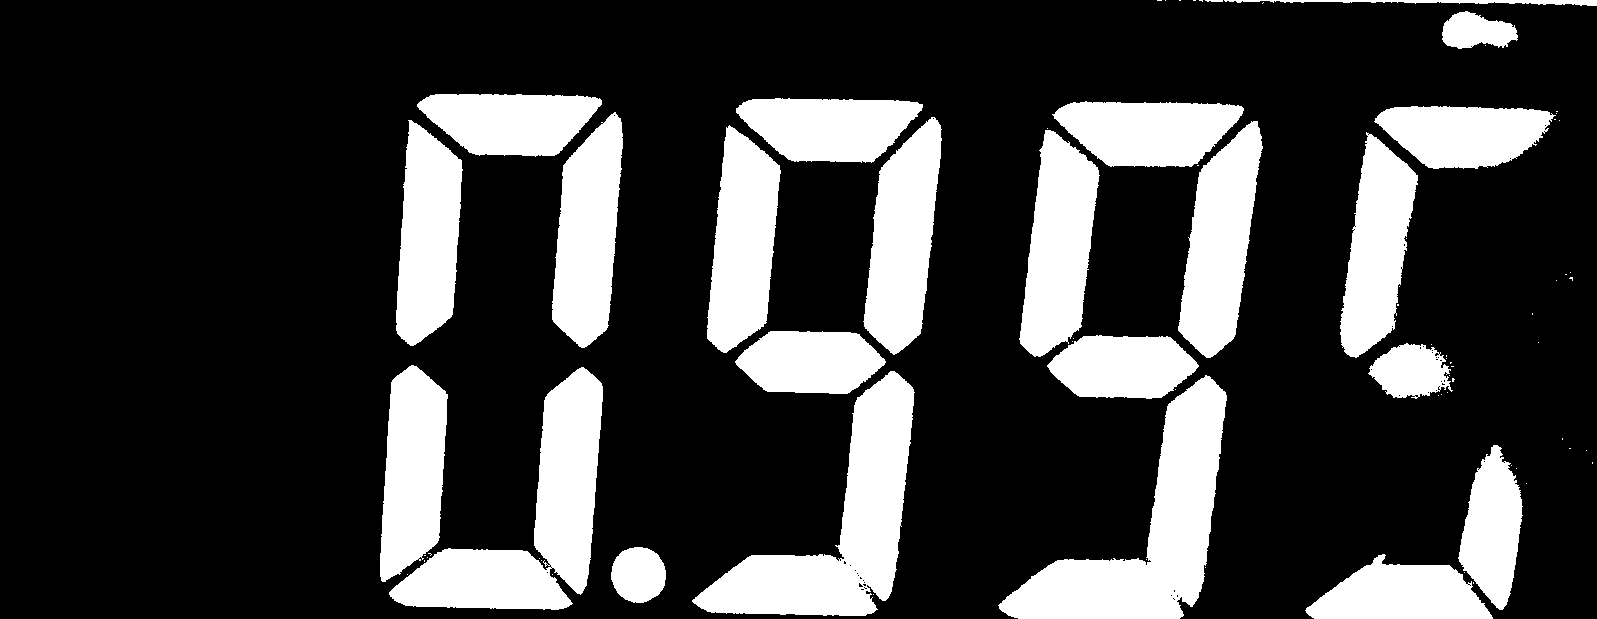

In [51]:
thr = graythresh(green) * 255;
thr
imshow((green < thr) .* 255)

In [52]:
blue = current(:, :, 3);

thr_blue =  157


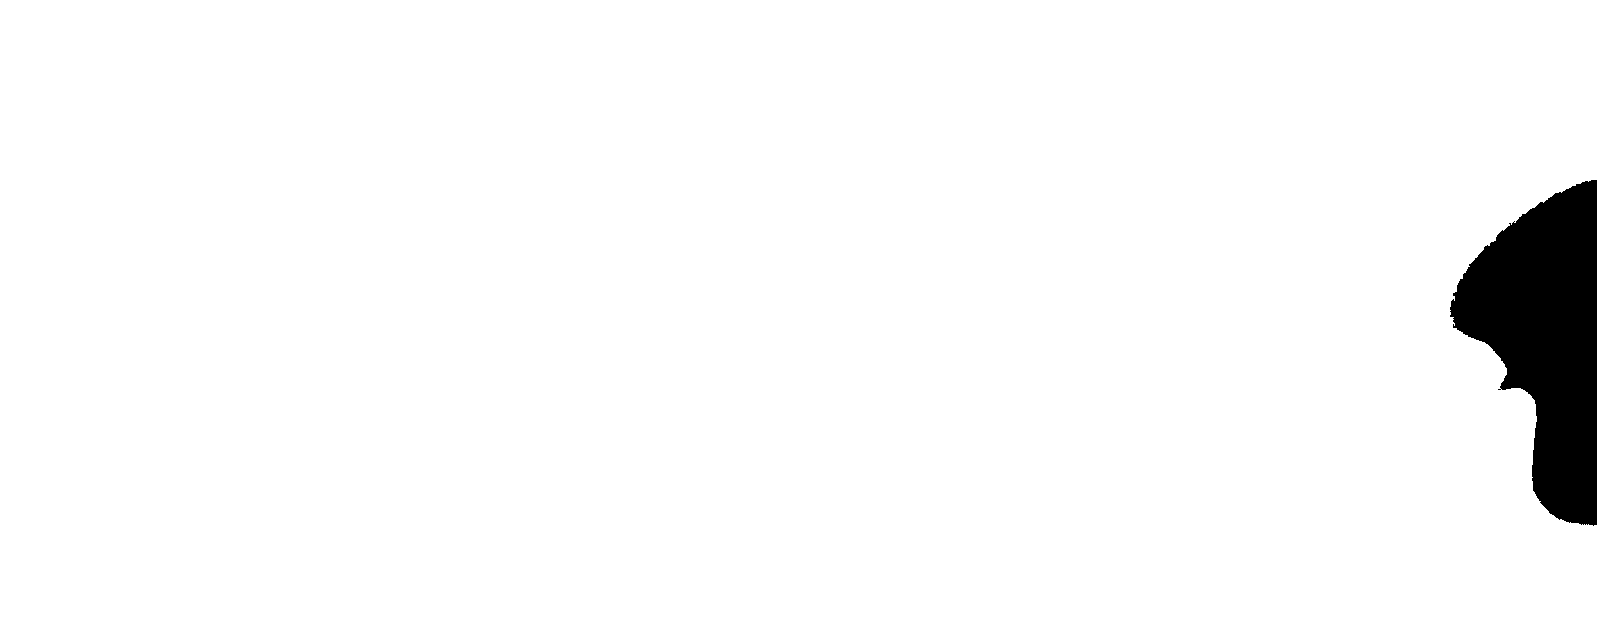

In [53]:
thr_blue = graythresh(blue) * 255;
thr_blue
imshow((blue < thr_blue) .* 255)

In [54]:
recovery_mask = (red > thr_red) + (blue > thr_blue);

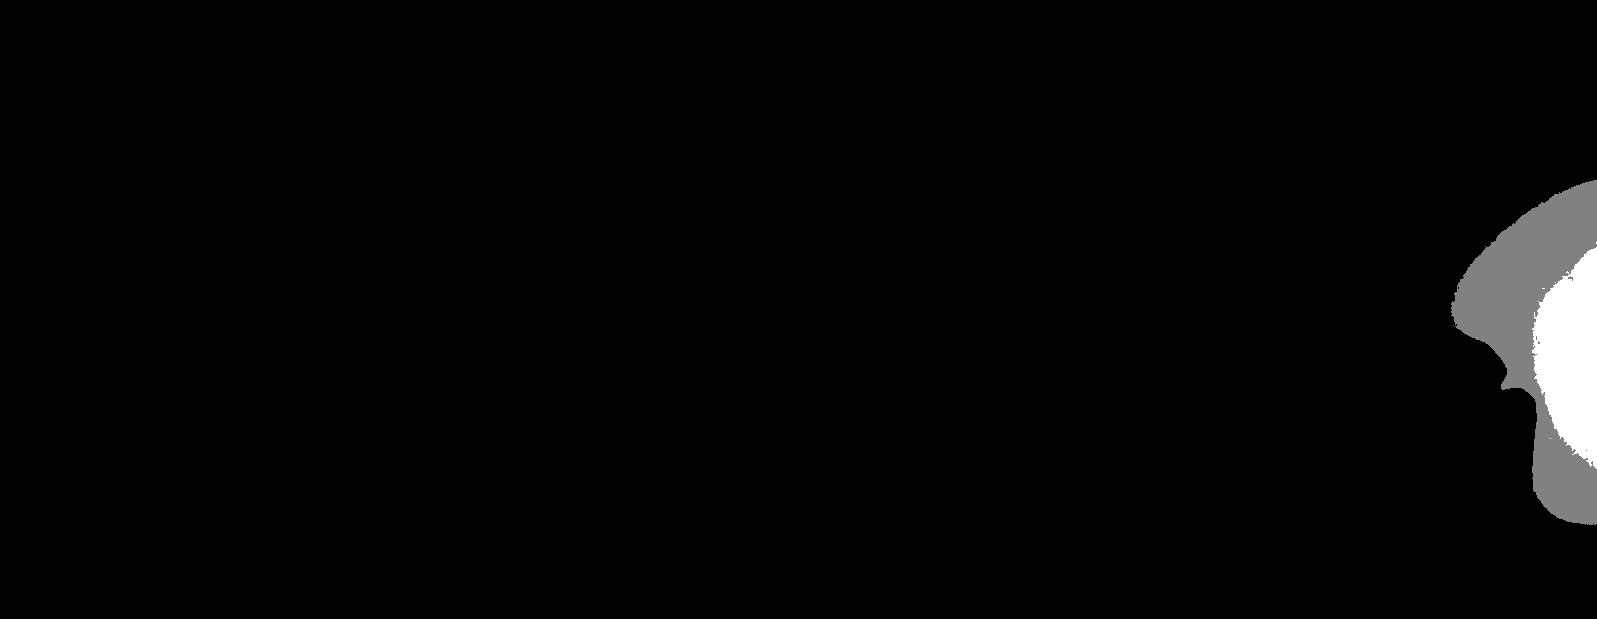

In [55]:
imshow(recovery_mask)

In [56]:
recovery_mask = recovery_mask == 0;

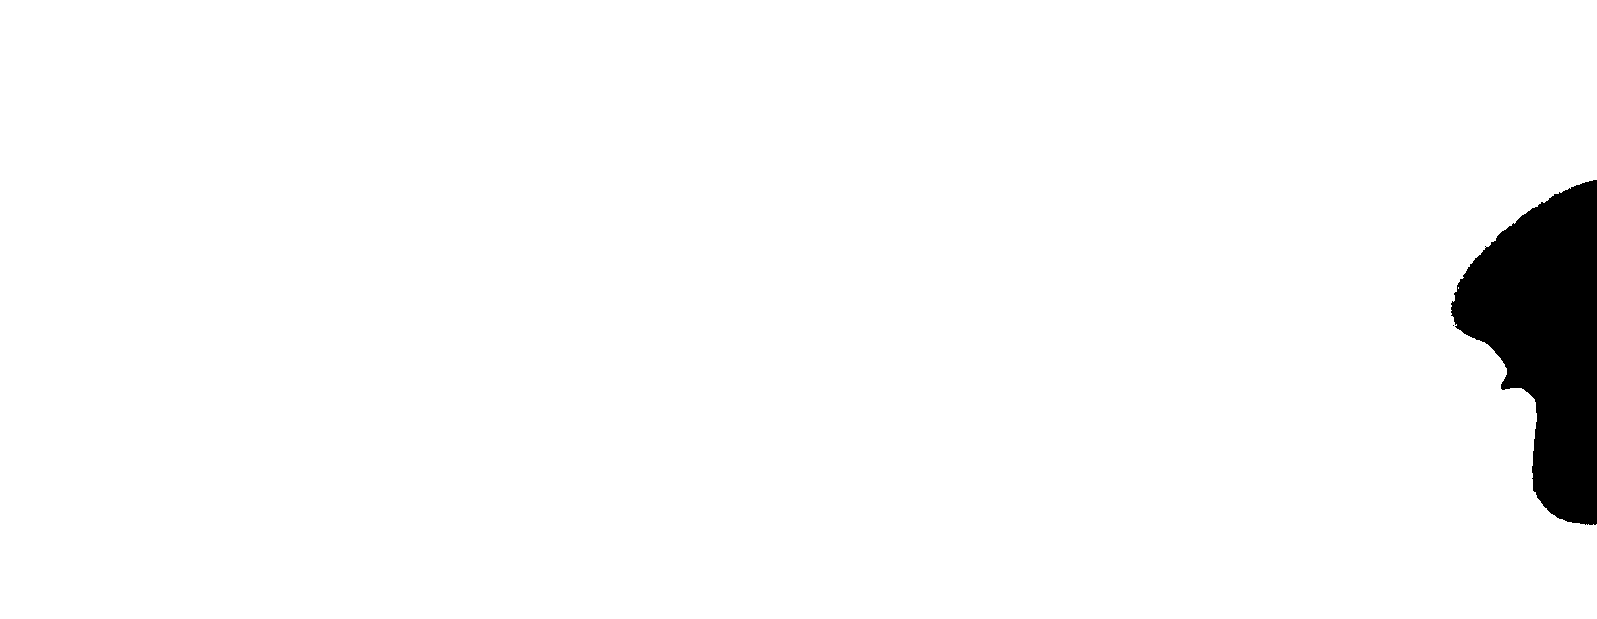

In [57]:
imshow(recovery_mask)

In [58]:
current = rgb2gray(current);

thr =  132


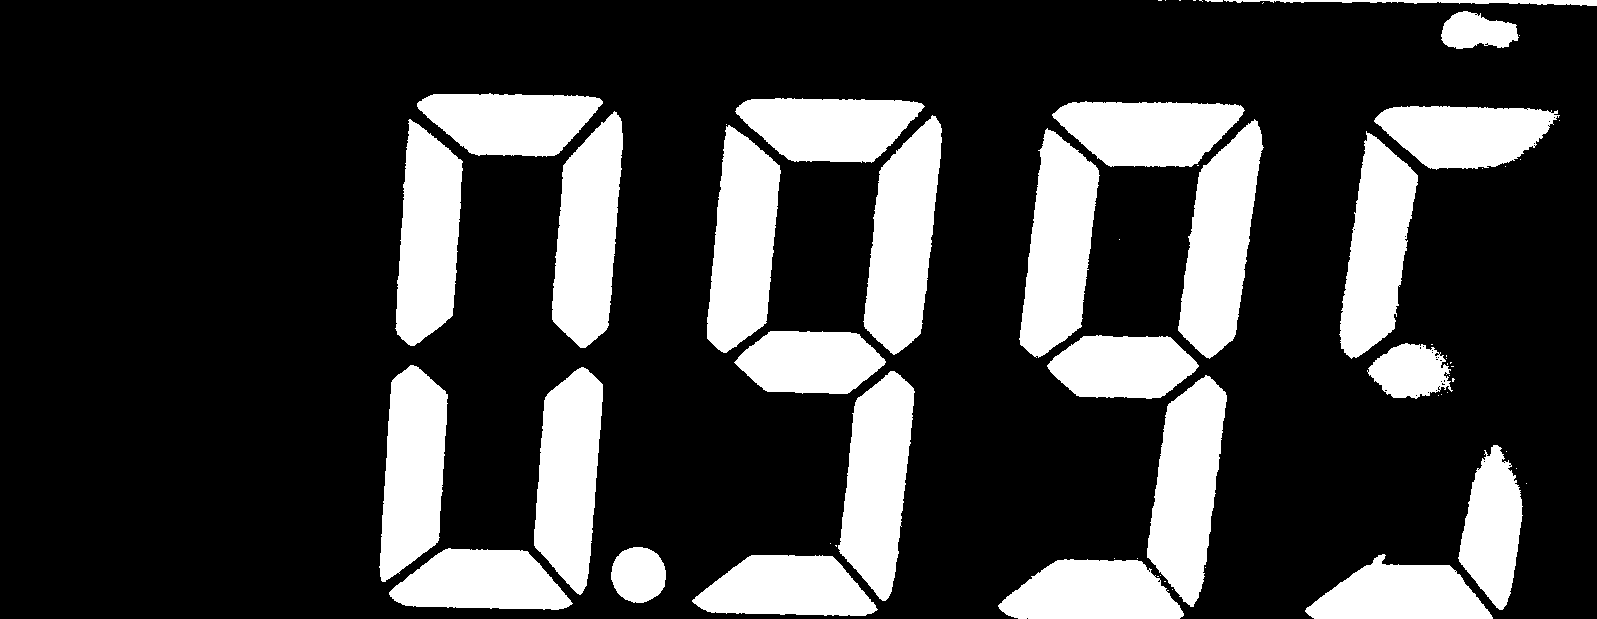

In [59]:
thr = graythresh(current) * 255;
thr
bin_current = (current < thr) .* 255;
imshow(bin_current)

In [60]:
current_eq = histEqualizer(current);

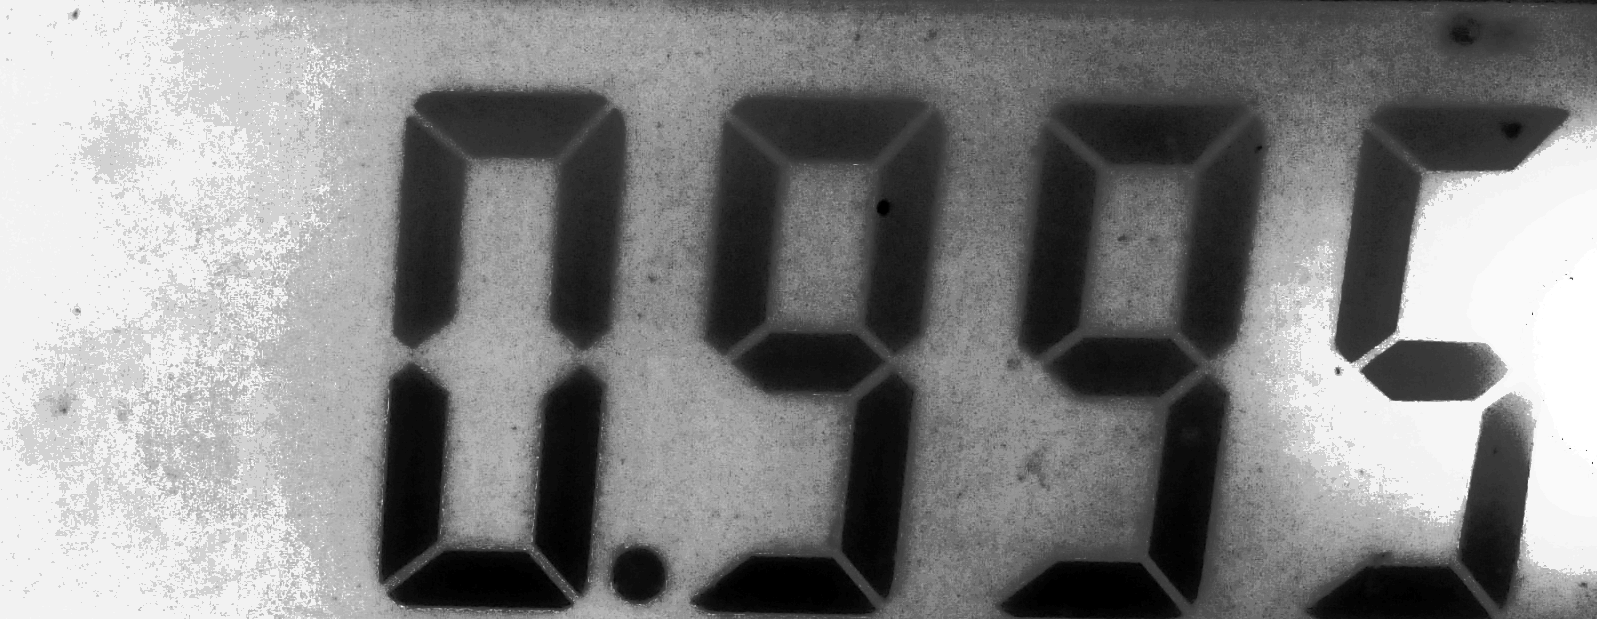

In [61]:
imshow(current_eq)

thr =  129.50


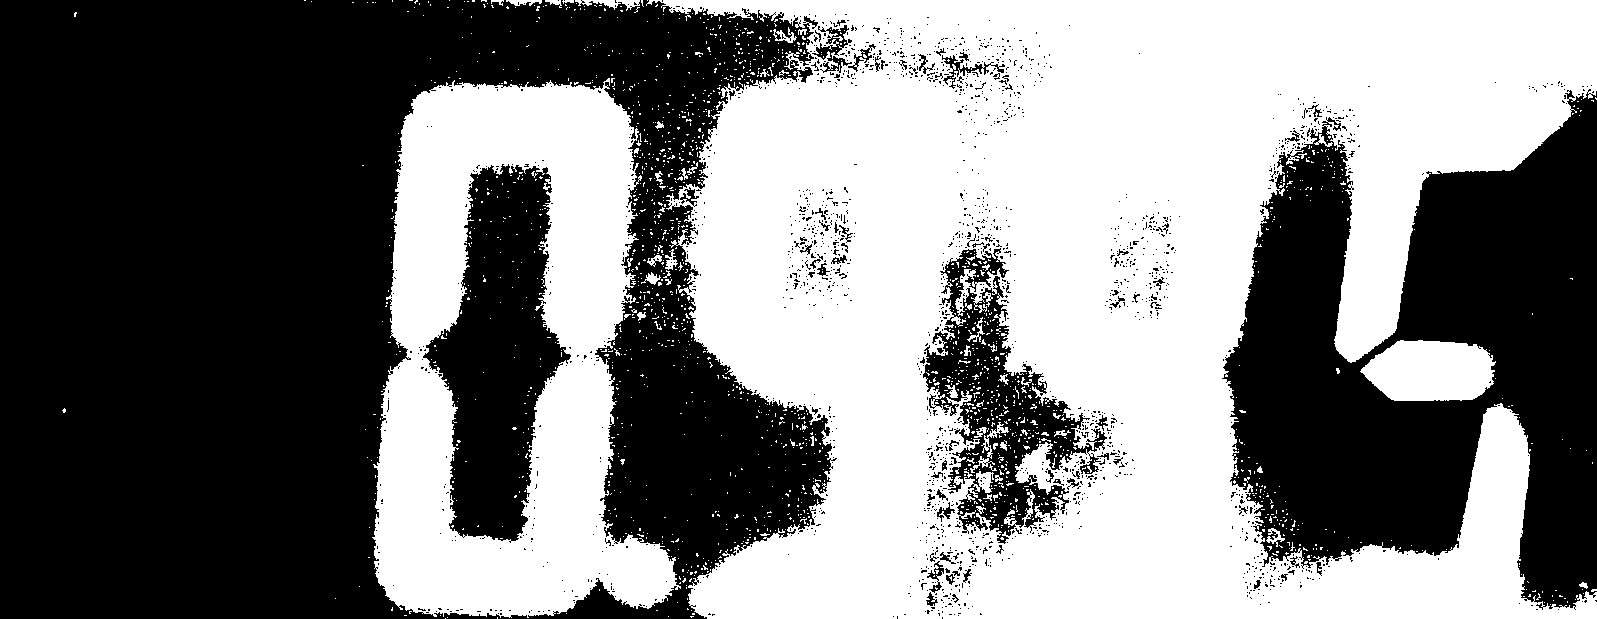

In [62]:
thr = graythresh(current_eq) * 255;
thr

bin_current_eq = (current_eq < thr) .* 255;
imshow(bin_current_eq)

In [63]:
ref_indx = find(recovery_mask == 0)';

In [64]:
size(bin_current_eq)

ans =

    619   1597



In [65]:
max_x = 0;
min_x = 9999;
max_y = 0;
min_y = 9999;
for ind = ref_indx
    [x,y] = ind2sub(size(recovery_mask), ind);
    
    if x > max_x
        max_x = x;
    end
    
    if y > max_y
        max_y = y;
    end
    
    if x < min_x
        min_x = x;
    end
    
    if y < min_y
        min_y = y;
    end
end

In [66]:
max_x
min_x
max_y
min_y 

max_x =  525
min_x =  181
max_y =  1597
min_y =  1452


In [67]:
min_y = floor(min_y * 0.95);

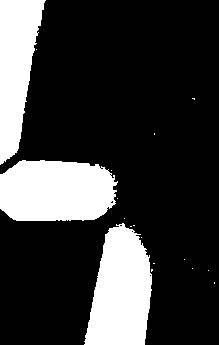

In [68]:
imshow(bin_current_eq(min_x:max_x, min_y:max_y))

In [69]:
perfect_bin = bin_current(:, :);

In [70]:
perfect_bin(min_x:max_x, min_y:max_y) = bin_current_eq(min_x:max_x, min_y:max_y);

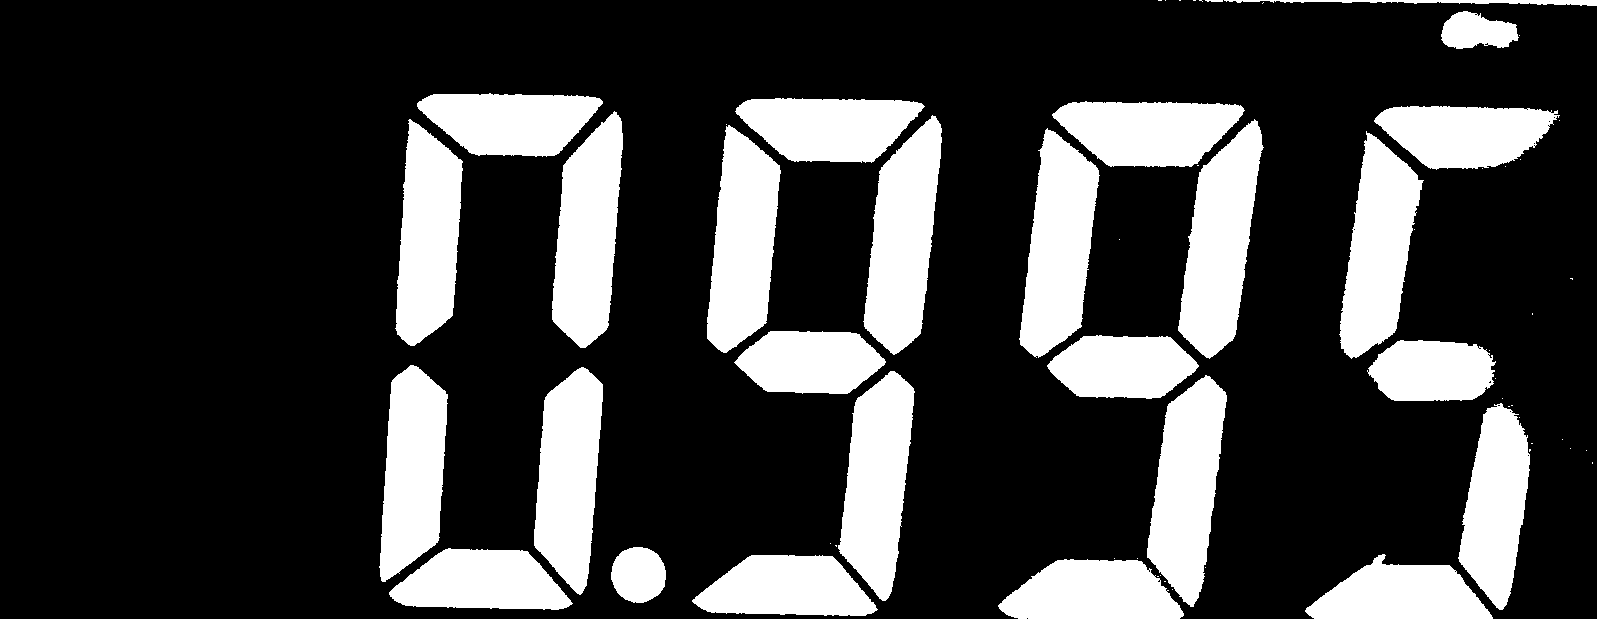

In [71]:
imshow(perfect_bin)

In [72]:
current = perfect_bin(:, :);

In [73]:
unique(current)

ans =

     0
   255



In [74]:
[x,y] = size(current)

x =  619
y =  1597


In [75]:
nhood = 5;

empt_C = double(ones(x,y));
for jj=[1:1:y]
    test = sum(current(:,jj) == 0);
    if test / x > 0.7
        empt_C(:, jj) = 0;
    end
end

empt_C_2 = double(zeros(x,y));
for jj=[1:1:y]
    if jj - nhood < 1
        ref_r = 1;
    else
        ref_r = jj - nhood;
    end
    
    if jj + nhood > y
        ref_l = y;
    else
        ref_l = jj + nhood;
    end
    
    test2_1 = aSum(empt_C(:,ref_r:ref_l) == 1);
    total = x * (1 + 2 * nhood);
    
    test = empt_C(:, jj);
    if test(1) == 1 
        if test2_1 / total  > 0.5
            empt_C_2(:, jj) = 1;
        end
    end
end


[first_x_C, first_y_C] = ind2sub(size(empt_C_2),min(find(empt_C_2 ~= 0)'))



empt_R = double(ones(x,y));
for ii=[1:1:x]
    test = sum(current(ii,first_y_C:end) == 0);
    if test / y > 0.7
        empt_R(ii,:) = 0;
    end
end

% nhood = 10
empt_R_2 = double(zeros(x,y));
for ii=[1:1:x]
    if ii - nhood < 1
        ref_u = 1;
    else
        ref_u = ii - nhood;
    end
    
    if ii + nhood > x
        ref_l = x;
    else
        ref_l = ii + nhood;
    end
    
    test2_1 = aSum(empt_R(ref_u:ref_l,:) == 1);
    total = y * (1 + 2 * nhood);
    
    test = empt_R(ii,:);
    if test(1) == 1 
        if test2_1 / total  > 0.5
            empt_R_2(ii, :) = 1;
        end
    end
end

[first_x_R, first_y_R] = ind2sub(size(empt_R_2),min(find(empt_R_2 ~= 0)'))

post_current = (empt_R + empt_C) .* double(current);

first_x_C =  1
first_y_C =  391
first_x_R =  96
first_y_R =  1


In [76]:
img_square = current(first_x_R:end, :);

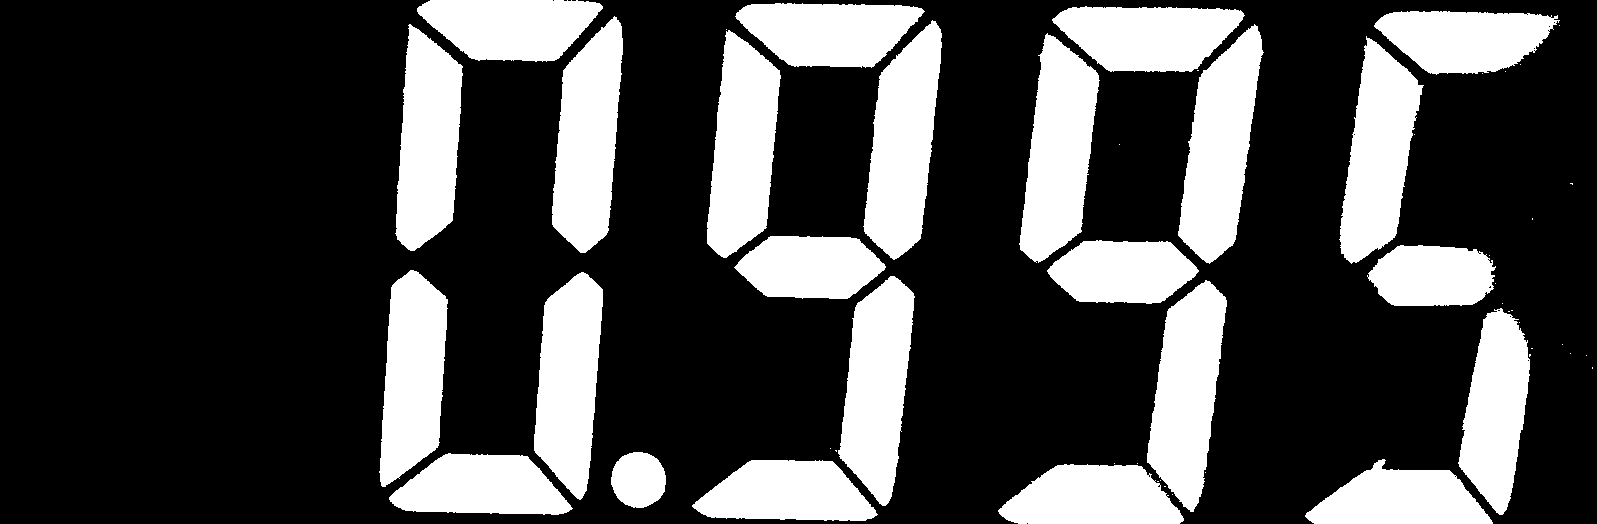

In [77]:
imshow(img_square)

In [78]:
ref_size = 56

ref_size =  56


In [79]:
y = 5 * ref_size + ((ref_size / 2) * 6)
x = ref_size  + ((ref_size / 2) * 2)

y =  448
x =  112


In [80]:
re_img_square = imresize(img_square, [x, y]);

In [81]:
re_img_square = uint8((re_img_square .* 255));

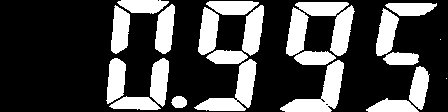

In [82]:
imshow(re_img_square)

In [83]:
% se = gen_struct(5,6);
se = gen_struct(3,3);

In [84]:
p_re_img_square = padding(re_img_square, 2, size(se));

In [85]:
close_post_img = morphologic_converter(p_re_img_square, 2, se, true);

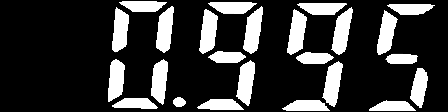

In [86]:
imshow(close_post_img)

In [87]:
se = gen_struct(5,6);
p_re_img_square_2 = padding(close_post_img, 2, size(se));
close_post_img_2 = morphologic_converter(p_re_img_square_2, 1, se, true);

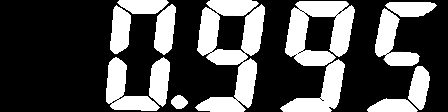

In [88]:
imshow(close_post_img_2)

In [89]:
size(close_post_img_2)

ans =

   112   448



In [90]:
map_ref = [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1];

In [91]:
ref_col = [1, cumsum(map_ref .* (ref_size / 2))]

ref_col =

     1    28    84   112   168   196   252   280   336   364   420   448



In [92]:
size_ref_col = size(ref_col);

In [93]:
ref_col([2:2:size_ref_col(2)])

ans =

    28   112   196   280   364   448



In [94]:
ranges = [ref_col(1:end-1); ref_col(2:end)]

ranges =

     1    28    84   112   168   196   252   280   336   364   420
    28    84   112   168   196   252   280   336   364   420   448



In [95]:
size_ranges = size(ranges)

size_ranges =

    2   11



In [96]:
spaced = zeros(ref_size * 2, ref_size * 2, 5);

In [97]:
size(spaced)

ans =

   112   112     5



In [98]:

for pair_ids = [2:2:size_ranges(2)]
    cols_0 = ranges(:, pair_ids - 1)';
    cols_0 = cols_0(1);
    
    if cols_0 > 1
        cols_0 = cols_0 + 1;
    end
    
    cols_1 = ranges(:, pair_ids + 1)';
    cols_1 = cols_1(2);

%     size(spaced(:, :, pair_ids / 2))
%     size(close_post_img_2(:, cols_0:cols_1))
    
%     disp(int2str(pair_ids / 2))
    
    spaced(:, :, pair_ids / 2) = close_post_img_2(:, cols_0:cols_1);
end

In [99]:
MNIST_SIZE = 28;

In [100]:
re_spaced = zeros(MNIST_SIZE,MNIST_SIZE,5);

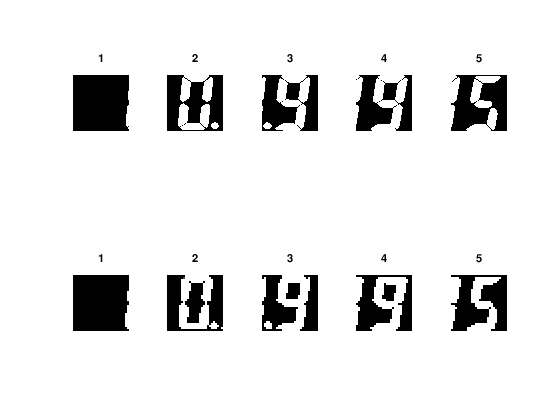

In [123]:
figure;
for ii = [1:1:5]
    re_spaced(:,:,ii) = imresize(spaced(:,:,ii), [MNIST_SIZE, MNIST_SIZE]);
    subplot(2,5,ii), imshow(spaced(:,:,ii)); title(int2str(ii));
    subplot(2,5,ii + 5), imshow(re_spaced(:,:,ii)); title(int2str(ii));
end

In [102]:
re_spaced = uint8(re_spaced);

In [103]:
save("./numbers_large.mat", 're_spaced', '-mat')

In [113]:
spaced_2 = zeros(ref_size * 2, ref_size * 2, 5);
size(spaced_2)

padd = ref_size/2

for pair_ids = [2:2:size_ranges(2)]
    cols = ranges(:,pair_ids)';
    
    
    spaced_2(:, padd+1:end-padd, pair_ids / 2) = close_post_img_2(:, cols(1)+1:cols(2));
end

ans =

   112   112     5

padd =  28


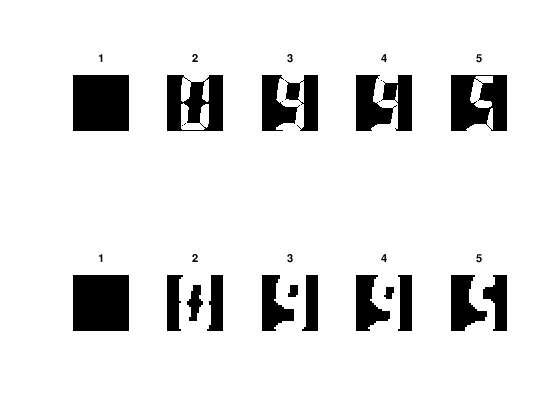

In [117]:
re_spaced_2 = zeros(MNIST_SIZE,MNIST_SIZE,5);

se = gen_struct(3,6);

figure;
for ii = [1:1:5]
    re_spaced_2(:,:,ii) = imresize(spaced_2(:,:,ii), [MNIST_SIZE, MNIST_SIZE]);
    
    p_re_re_img = padding(re_spaced_2(:,:,ii), 2, size(se));
    close_post_img_2 = morphologic_converter(p_re_re_img, 1, se, true);
    
    re_spaced_2(:,:,ii) = close_post_img_2;
    
    subplot(2,5,ii), imshow(spaced_2(:,:,ii)); title(int2str(ii));
    subplot(2,5,ii + 5), imshow(close_post_img_2); title(int2str(ii));
end

save("./numbers_short.mat", 're_spaced_2', '-mat')